# simple synthetic inversion

Here we try to recover the true Layer 1 topography with a gravity inversion. We start with the forward gravity of Layer 1 as the observed gravity, then down-sample this gravity to represent a coarser gravity survey, and final, repeate these steps with a regional component including in the observed gravity. The regional component is the forward gravity of Layer 2. 

We also explore adding gaussian noise to these gravity data. 

The starting (low-resolution) Layer 1 topography has been created through the random sampling and gridding of 30 points. In an Antarctic setting, these points represent single seismic survey locations which measure the elevation of Layer 1. 

import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

from RIS_gravity_inversion import plotting, optimization, synthetic, regional
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.utils as inv_utils

import copy
from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings
import os
import pathlib

# Load data

## topographic layers
* 2 full resolution synthetic layers
* low resolution layer 2

In [3]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2.zarr").z

starting_layer1 = xr.open_zarr("../synthetic_data/synthetic_lowres_layer1_with_border.zarr").z

# ensure all xarray are same data type
layer1 = layer1.astype(np.float64)
layer2 = layer2.astype(np.float64)
starting_layer1 = starting_layer1.astype(np.float64)

print(utils.get_grid_info(layer1))
print(utils.get_grid_info(layer2))
print(utils.get_grid_info(starting_layer1))
starting_layer1

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.10/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -952.152099609, -481.448486328, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -4689.66455078, -3614.13256836, 'g')
(1000.0, [-6000.0, 86000.0, -6000.0, 66000.0], -877.008483887, -478.95703125, 'g')


<xarray.DataArray 'z' (northing: 73, easting: 93)>
dask.array<open_dataset-d83552a559fc4e0fdd985b70d748c164z, shape=(73, 93), dtype=float64, chunksize=(73, 93), chunktype=numpy.ndarray>
Coordinates:
  * easting   (easting) float64 -6e+03 -5e+03 -4e+03 ... 8.4e+04 8.5e+04 8.6e+04
  * northing  (northing) float64 -6e+03 -5e+03 -4e+03 ... 6.5e+04 6.6e+04
Attributes:
    metadata:  Generated by Spline()

## gravity data
* full resolution forward gravity of Layer 1
* full resolution with regional component
* sampled forward gravity of Layer 1
* sampled with regional component

In [4]:
# full resolution gravity point data
grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
# sampled gravity point data
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_regional_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# Set region and parameters

Use the same regions and parameters as `synthetic_model_2layer.ipynb`

In [5]:
layer_spacing, buffer_region, _, _, registration = utils.get_grid_info(layer2)

# set gravity observation parameters
grav_observation_height = 1e3
grav_spacing = 1e3
sampled_grav_spacing = 2e3

inversion_region = utils.alter_region(
    buffer_region,
    zoom=6e3,
)[0]

# set density contrast
density = 2300 - 1024

print(f"spacing: {layer_spacing}m")
print(f"registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 1000.0m
registration: g
inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-6000.0, 86000.0, -6000.0, 66000.0]


# Prep data

## grav data

In [6]:
full_res_grav = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="Surface1",
    input_coord_names=("easting", "northing", "upward"),
)
full_res_grav_with_reg = inv_utils.prep_grav_data(
    grav,
    region=inversion_region,
    input_grav_name="forward_total",
    input_coord_names=("easting", "northing", "upward"),
)
sampled_grav = inv_utils.prep_grav_data(
    sampled_grav,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)
sampled_grav_with_reg = inv_utils.prep_grav_data(
    sampled_grav_with_reg,
    region=inversion_region,
    input_grav_name="Gobs",
    input_coord_names=("easting", "northing", "upward"),
)

print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled gravity: {len(sampled_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.upward))}")

full resolution gravity: 4941 points
sampled gravity: 1271 points
gravity avg. elevation: 1000


## constraint points

In [6]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/synthetic_constraints_with_border.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all, inversion_region, names=("easting", "northing")
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:48


easting      northing      upward
0  43905.080314  15873.336726 -760.945963
1  57215.149310  46454.021366 -683.774158
2  48221.070086  27369.019933 -671.064790
3  43590.654640  34106.036932 -723.355993
4  33892.383947   1127.388026 -723.326865

## plot inputs

In [8]:
# # grid the observed gravity
# Gobs = full_res_grav_with_reg.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 2
# fig = maps.plot_grd(
#     grid=layer2,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Layer 2",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="c)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

In [ ]:
# # grid the observed gravity
# Gobs = full_res_grav.set_index(["northing", "easting"]).to_xarray().Gobs

# # plot observed gravity
# fig = maps.plot_grd(
#     grid=Gobs,
#     fig_height=8,
#     cmap="vik",
#     region=buffer_region,
#     title="Gravity anomaly",
#     cbar_unit="mGal",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="a)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# # plot layer 1
# fig = maps.plot_grd(
#     grid=starting_layer1,
#     fig_height=8,
#     cmap="rain",
#     reverse_cpt=True,
#     region=buffer_region,
#     grd2cpt=True,
#     title="Starting Layer 1",
#     cbar_label="elevation",
#     cbar_unit="m",
#     show_region=inversion_region,
#     hist=True,
#     cbar_yoffset=3,
#     fig=fig,
#     origin_shift="xshift",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )
# fig.text(
#     position="TL",
#     justify="BL",
#     text="b)",
#     font="26p,Helvetica,black",
#     offset="j0/.3",
#     no_clip=True,
# )

# fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the starting Layer 1 density contrast. This will be the input into our inversion.


## layer 1 prisms

In [9]:
# create prisms around starting layer 1
# positive densities above reference, negative below
print(f"Layer 1 density contrast: {density}kgm-3")

layer1_prisms = inv_utils.grids_to_prisms(
    surface=starting_layer1,
    reference=starting_layer1.values.mean(),
    density=xr.where(
        starting_layer1 >= starting_layer1.values.mean(), density, -density),
)

# plotting.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

Layer 1 density contrast: 1276kgm-3


## layer 1 gravity

In [ ]:
# # calculate gravity of layer1
# layer1_grav_grid, layer1_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [layer1_prisms],
#     full_res_grav,
#     names=["layer1_prisms"],
#     remove_median=False,
#     progressbar=True,
#     plot=False,
# )

# full_res_grav["layer1_forward"] = layer1_grav_df.forward_total
# full_res_grav_with_reg["layer1_forward"] = layer1_grav_df.forward_total

# full_res_grav

In [ ]:
# # repeat with sampled gravity
# layer1_sampled_grav_grid, layer1_sampled_grav_df = inv_utils.forward_grav_of_prismlayer(
#     [layer1_prisms],
#     sampled_grav,
#     names=["layer1_prisms"],
#     remove_median=False,
#     progressbar=True,
#     plot=False,
# )

# sampled_grav["layer1_forward"] = layer1_sampled_grav_df.forward_total
# sampled_grav_with_reg["layer1_forward"] = layer1_sampled_grav_df.forward_total

# sampled_grav

## Misfit

In [ ]:
# full_res_grav = inv.misfit(
#     input_grav=full_res_grav,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraint_points,
# )
# full_res_grav_with_reg = inv.misfit(
#     input_grav=full_res_grav_with_reg,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraint_points,
# )
# sampled_grav = inv.misfit(
#     input_grav=sampled_grav,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraint_points,
# )
# sampled_grav_with_reg = inv.misfit(
#     input_grav=sampled_grav_with_reg,
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     constraints=constraint_points,
# )

### Save and load results

In [ ]:
# full_res_grav.to_csv(
#     "../synthetic_data/synthetic_simple_starting_model_forward_gravity_with_border.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# full_res_grav_with_reg.to_csv(
#     "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity_with_border.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# sampled_grav.to_csv(
#     "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity_with_border.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )
# sampled_grav_with_reg.to_csv(
#     "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity_with_border.csv.gz",
#     sep=",",
#     na_rep="",
#     header=True,
#     index=False,
#     encoding="utf-8",
#     compression="gzip",
# )

In [7]:
full_res_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_starting_model_forward_gravity_with_border.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_with_reg_starting_model_forward_gravity_with_border.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_starting_model_forward_gravity_with_border.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
sampled_grav_with_reg = pd.read_csv(
    "../synthetic_data/synthetic_simple_sampled_with_reg_starting_model_forward_gravity_with_border.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
full_res_grav

northing  easting      Gobs  Surface2  forward_total  upward  \
0          0.0      0.0  4.895946 -1.585934       3.310012  1000.0   
1          0.0   1000.0  4.764286 -1.697236       3.067050  1000.0   
2          0.0   2000.0  4.616825 -1.806994       2.809832  1000.0   
3          0.0   3000.0  4.458949 -1.915200       2.543749  1000.0   
4          0.0   4000.0  4.294071 -2.021884       2.272188  1000.0   
...        ...      ...       ...       ...            ...     ...   
4936   60000.0  76000.0  0.829439  8.586936       9.416375  1000.0   
4937   60000.0  77000.0  0.825047  8.508668       9.333715  1000.0   
4938   60000.0  78000.0  0.822520  8.397605       9.220126  1000.0   
4939   60000.0  79000.0  0.821311  8.246703       9.068014  1000.0   
4940   60000.0  80000.0  0.820536  8.046806       8.867341  1000.0   

      layer1_forward  Gobs_shift    misfit  
0           4.918955    4.894330 -0.024625  
1           4.798930    4.762670 -0.036261  
2           4.665710    4.615209 -0.050501  
3           4.523598    4.457333 -0.066265  
4           4.373681    4.292455 -0.081225  
...              ...         ...       ...  
4936        0.851258    0.827823 -0.023436  
4937        0.843413    0.823431 -0.019982  
4938        0.838053    0.820904 -0.017149  
4939        0.834626    0.819695 -0.014931  
4940        0.832120    0.818919 -0.013201  

[4941 rows x 9 columns]

gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.
gmtset [WARNING]: Representation of font type not recognized. Using default.


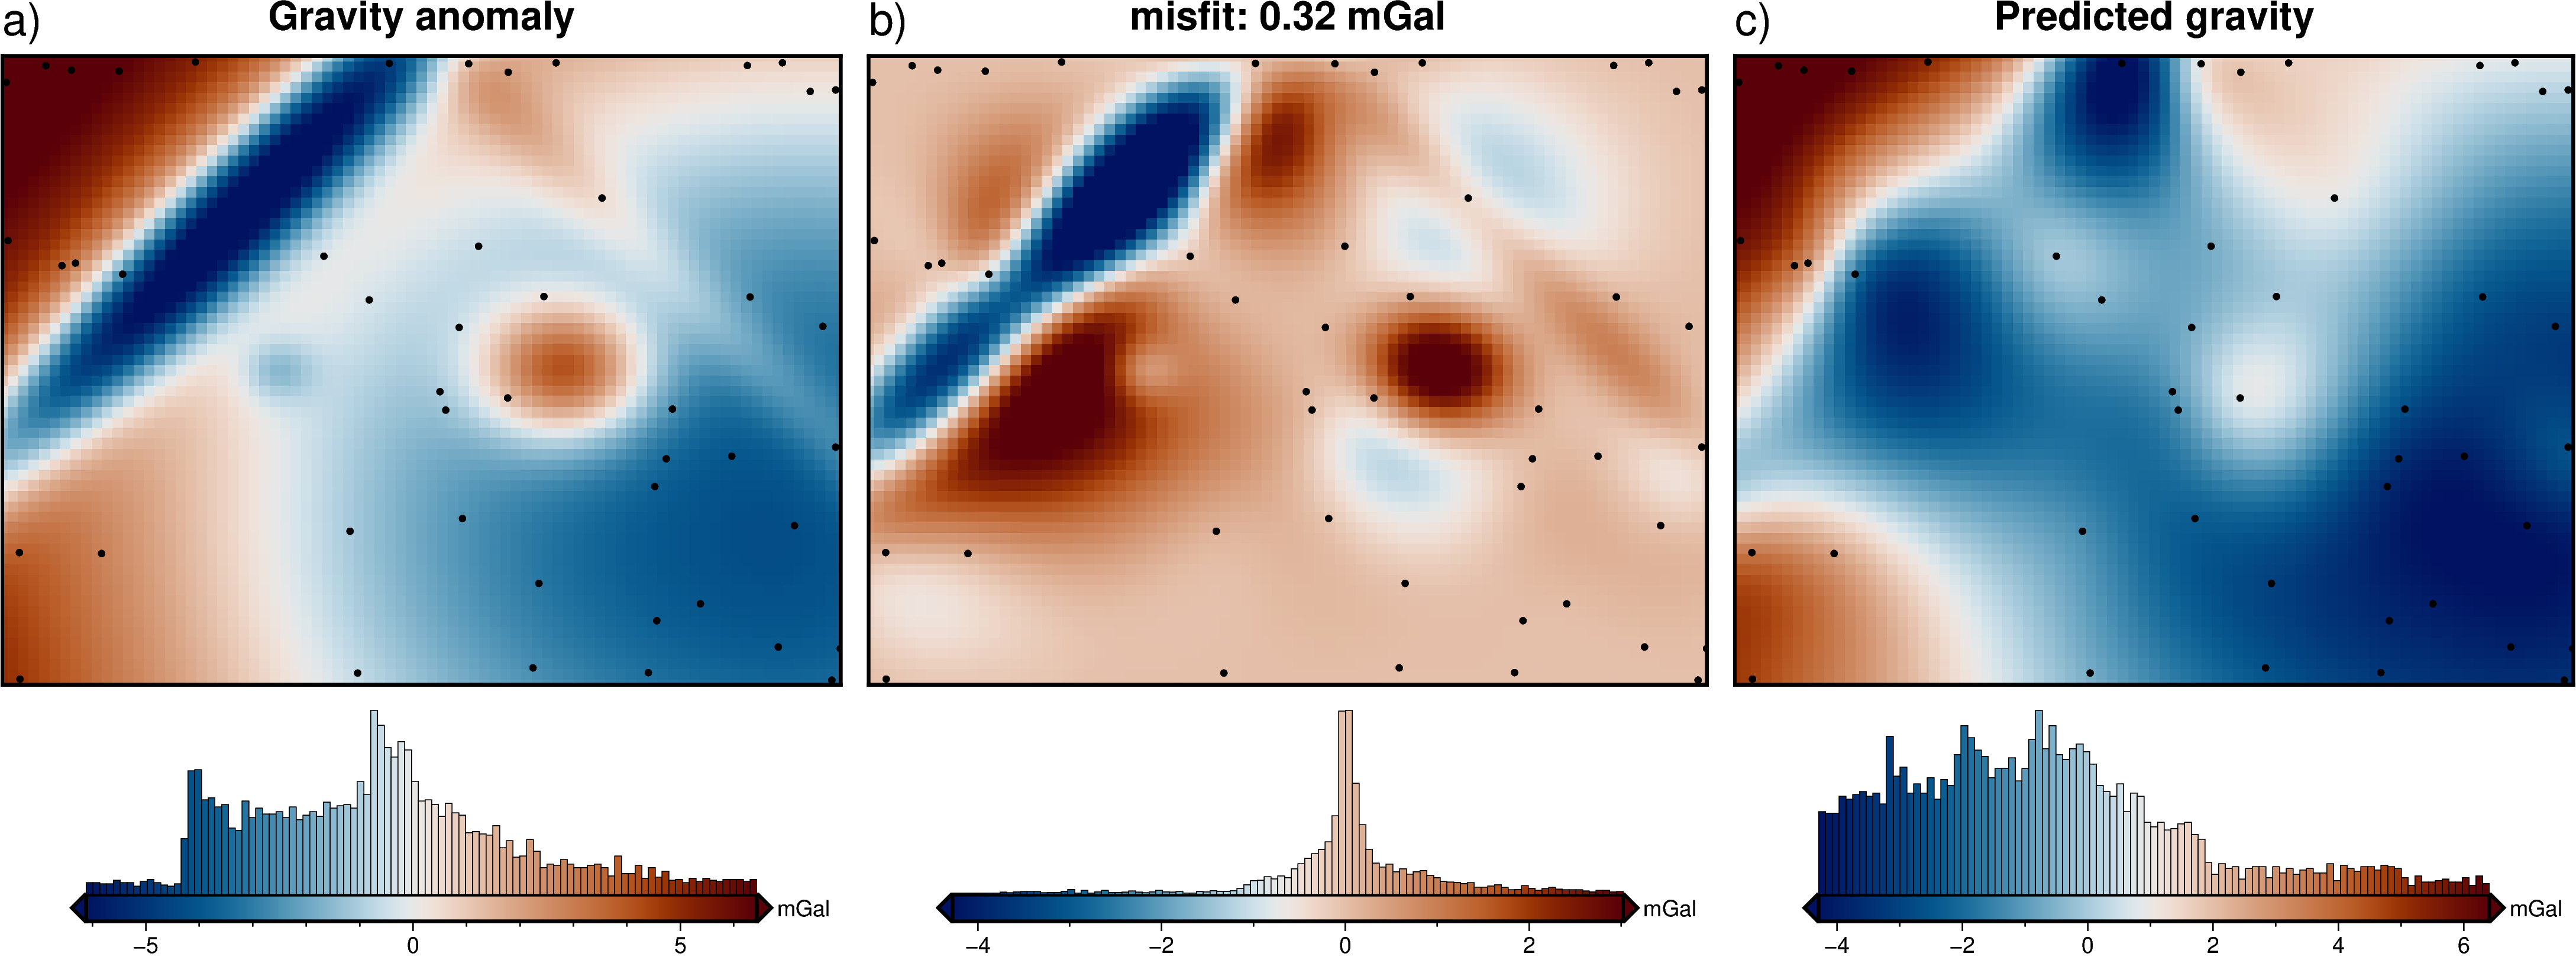

In [8]:
plotting.misfit_plotting(
    full_res_grav,
    # grav_spacing=grav_spacing,
    plot_type="pygmt",
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)

In [ ]:
# plotting.misfit_plotting(
#     sampled_grav,
#     # grav_spacing=sampled_grav_spacing,
#     plot_type="pygmt",
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs_shift",
#     constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.1c",
# )

# Constraints grid

In [ ]:
# starting_prisms = copy.deepcopy(layer1_prisms)

# weights, min_dist = inv_utils.constraints_grid(
#     constraint_points,
#     starting_prisms,
#     inner_bound=1e3,
#     outer_bound=4e3,
#     low=0,
#     high=1,
#     # region=inversion_region,
#     interp_type="spline",
#     # tension_factor = .35,
#     # plot = True,
# )
# starting_prisms["weights"] = weights
# starting_prisms["min_dist"] = min_dist
# weights.plot()

### Save to Zarr

In [ ]:
# enc = {x: {"compressor": zarr.Blosc()} for x in starting_prisms}
# starting_prisms.to_zarr(
#     "../synthetic_data/synthetic_starting_prisms_with_border.zarr",
#     encoding=enc,
#     mode="w",
# )

In [11]:
starting_prisms = xr.open_zarr("../synthetic_data/synthetic_starting_prisms_with_border.zarr")

In [ ]:
# fig = maps.plot_grd(
#     starting_prisms.weights,
#     fig_height=10,
#     title="Weighting grid",
#     cbar_label="weights",
#     cmap="dense",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.15c",
# )
# fig = maps.plot_grd(
#     starting_prisms.min_dist,
#     fig=fig,
#     origin_shift="xshift",
#     title="Minumum distance to constraints",
#     cbar_label="m",
#     cmap="viridis",
#     points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     points_style="c0.15c",
# )

# fig.show()

# Inversion with no regional
## Set regional component to 0 for simple models

In [ ]:
full_res_grav["reg"] = 0
full_res_grav["res"] = full_res_grav.misfit
print(full_res_grav.res.median())

sampled_grav["reg"] = 0
sampled_grav["res"] = sampled_grav.misfit
print(sampled_grav.res.median())
full_res_grav

In [ ]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=100,
#     l2_norm_tolerance=0.01,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
#     # apply_weights = True,
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 10**-2,   
# )

# results = inv.inversion_RMSE(
    
#     # input_grav=full_res_grav,
#     input_grav=sampled_grav,
    
#     inversion_region=inversion_region,
#     true_surface = layer1,
#     constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     plot=True,
#     plot_type="xarray",
#     **kwargs,
# )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,

#         # grav_spacing=grav_spacing,
#         grav_spacing=sampled_grav_spacing,

#         constraints=constraint_points,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [ ]:

# set kwargs for inversion
kwargs = dict(
    input_grav=full_res_grav,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_no_reg_inversion_damping_weights_with_border"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))


In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 20e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

## Repeat with sampled data

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav=sampled_grav,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=100,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_no_reg_inversion_damping_weights_with_border"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

# Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `Surface 2` and `Surface 3`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `Surface 2` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of `Surface 2`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `Surface 2` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `Surface 2` and the low-resolution `Surface 2`. 

If we fail to accurately remove the `regional` signal, the resulting `Surface 2` surface after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we create the synthetic model, we precisely know the regional component (the forward gravity of `Surface 3`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

## Calculate regional component for other models 

In [12]:
regional_kwargs = dict(
    input_grav=full_res_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=full_res_grav.set_index(["northing","easting"]).to_xarray().Surface2,
    constraints=constraint_points,
)

# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"synthetic_simple_region_sep_indiv_with_border_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"
    
#     # remove if exists
#     # pathlib.Path(fname).unlink(missing_ok=True)

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     # set number of runs per method
#     n_trials=20
    
#     # define search space if using GridSampler
#     # search_space = {
#     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
#     #     # "weights_inner": np.arange(1e3, 1900, step=100),
#     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
#     # }
#     # create study
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="BoTorch")
#         study = optuna.create_study(
#             study_name=study_name,
#             storage=storage,
#             direction="minimize",
#             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#             # sampler=optuna.samplers.GridSampler(search_space),
#             load_if_exists=True,
#             )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 500e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#                 parallel=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"synthetic_simple_region_sep_indiv_with_border_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))
        
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    # plotting.plot_best_param(
    #     study_df, comparison_method, regional_method=i, **regional_kwargs
    # )
    # optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

In [13]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
77      17  0.732651 2023-04-16 10:08:33.414570 2023-04-16 10:08:52.198593   
72      12  0.738795 2023-04-16 10:08:33.547958 2023-04-16 10:08:51.422977   
65       5  0.752819 2023-04-16 10:08:33.396817 2023-04-16 10:08:47.111912   
73      13  0.758100 2023-04-16 10:08:33.406867 2023-04-16 10:08:51.251728   
36      16  0.761525 2023-04-16 10:08:06.581929 2023-04-16 10:08:15.426043   

                 duration  params_filter     state params_method  \
77 0 days 00:00:18.784023            NaN  COMPLETE    eq_sources   
72 0 days 00:00:17.875019            NaN  COMPLETE    eq_sources   
65 0 days 00:00:13.715095            NaN  COMPLETE    eq_sources   
73 0 days 00:00:17.844861            NaN  COMPLETE    eq_sources   
36 0 days 00:00:08.844114            NaN  COMPLETE         trend   

    params_trend  params_constraints  params_eq_sources  
77           NaN                 NaN          1700000.0  
72           NaN                 NaN          1540000.0  
65           NaN                 NaN          1500000.0  
73           NaN                 NaN          1250000.0  
36           4.0                 NaN                NaN

In [14]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best filter: index {best_filter}")
print(f"best trend: index {best_trend}")
print(f"best constraints: index {best_constraints}")
print(f"best eq sources: index {best_eq_sources}")

best filter: index 15
best trend: index 16
best constraints: index 13
best eq sources: index 17


In [15]:
regional_method = df.iloc[0].params_method
print(f"best method: {regional_method}")

param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]
print(f"best parameter: {param}")

best method: eq_sources
best parameter: 1700000.0


In [16]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# param = .25

# get best param from chosen method.
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=grav_spacing,
    **regional_kwargs,
)

# anom_grids = plotting.anomalies_plotting(
#     df_anomalies,
#     region=inversion_region,
#     grav_spacing=grav_spacing,
#     title=f" Method: {regional_method}, parameter: {param}",
#     constraints=constraint_points.rename(columns={"easting":"x","northing":"y"}),
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     plot_type="pygmt",
#     robust=False,
# )

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

## repeat with sampled grav

In [17]:
regional_kwargs = dict(
    input_grav=sampled_grav_with_reg,
    input_forward_column="layer1_forward",
    input_grav_column="Gobs_shift",
    grav_spacing=sampled_grav_spacing,
    inversion_region=inversion_region,
    true_regional=full_res_grav.set_index(["northing","easting"]).to_xarray().Surface2,
    constraints=constraint_points,
)

# set comparison method
# comparison_method='minimize_constraints'
comparison_method = "regional_comparison"

methods = ["filter", "trend", "constraints", "eq_sources"]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"synthetic_simple_sampled_region_sep_indiv_with_border_{i}_{comparison_method}"
#     fname = f"../optimization_logs/{study_name}.log"
    
#     # remove if exists
#     # pathlib.Path(fname).unlink(missing_ok=True)

#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="JournalStorage is experimental")
#         storage = JournalStorage(JournalFileStorage(fname))

#     # set number of runs per method
#     n_trials=20
    
#     # define search space if using GridSampler
#     # search_space = {
#     #     "damping": np.arange(-6, 1, step=2, dtype="float"),
#     #     # "weights_inner": np.arange(1e3, 1900, step=100),
#     #     "weights_outer": np.arange(2e3, 20e3, step=4e3, dtype="float"),
#     # }
#     # create study
#     with warnings.catch_warnings():
#         warnings.filterwarnings("ignore", message="BoTorch")
#         study = optuna.create_study(
#             study_name=study_name,
#             storage=storage,
#             direction="minimize",
#             # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#             sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#             # sampler=optuna.samplers.GridSampler(search_space),
#             load_if_exists=True,
#             )

#     # define the objective function
#     objective = optimization.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 500e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 5000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = optimization.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#                 parallel=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"synthetic_simple_sampled_region_sep_indiv_with_border_{i}_{comparison_method}"
    fname = f"../optimization_logs/{study_name}.log"
        
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message="JournalStorage is experimental")
        storage = JournalStorage(JournalFileStorage(fname))
        
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df)

    # plot results
    # plotting.plot_best_param(
    #     study_df, comparison_method, regional_method=i, **regional_kwargs
    # )
    # optuna.visualization.plot_slice(study).show()

studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v["params_method"] = k

regional_sep_combined_studies = pd.concat(
    studies.values(), ignore_index=True
).sort_values(by="value")

[I 2023-04-16 13:04:38,620] Using an existing study with name 'synthetic_simple_sampled_region_sep_indiv_with_border_filter_regional_comparison' instead of creating a new one.


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-16 13:04:59,905] Using an existing study with name 'synthetic_simple_sampled_region_sep_indiv_with_border_trend_regional_comparison' instead of creating a new one.


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-16 13:05:12,771] Using an existing study with name 'synthetic_simple_sampled_region_sep_indiv_with_border_constraints_regional_comparison' instead of creating a new one.


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

[I 2023-04-16 13:05:32,684] Using an existing study with name 'synthetic_simple_sampled_region_sep_indiv_with_border_eq_sources_regional_comparison' instead of creating a new one.


Optimizing:   0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
133      13  0.677656 2023-04-16 10:11:45.415202 2023-04-16 10:11:56.540433   
129       9  0.716949 2023-04-16 10:11:45.399240 2023-04-16 10:11:52.431612   
132      12  0.724984 2023-04-16 10:11:45.402840 2023-04-16 10:11:55.401130   
153      33  0.736106 2023-04-16 13:05:32.734595 2023-04-16 13:05:49.777225   
141      21  0.742722 2023-04-16 13:05:32.701802 2023-04-16 13:05:34.894291   

                  duration  params_filter     state params_method  \
133 0 days 00:00:11.125231            NaN  COMPLETE    eq_sources   
129 0 days 00:00:07.032372            NaN  COMPLETE    eq_sources   
132 0 days 00:00:09.998290            NaN  COMPLETE    eq_sources   
153 0 days 00:00:17.042630            NaN  COMPLETE    eq_sources   
141 0 days 00:00:02.192489            NaN  COMPLETE    eq_sources   

     params_trend  params_constraints  params_eq_sources  
133           NaN                 NaN          2240000.0  
129           NaN                 NaN          2090000.0  
132           NaN                 NaN          2040000.0  
153           NaN                 NaN          1780000.0  
141           NaN                 NaN          1720000.0

In [19]:
best_filter = df[df.params_method == "filter"].iloc[0].number
best_trend = df[df.params_method == "trend"].iloc[0].number
best_constraints = df[df.params_method == "constraints"].iloc[0].number
best_eq_sources = df[df.params_method == "eq_sources"].iloc[0].number

print(f"best filter: index {best_filter}")
print(f"best trend: index {best_trend}")
print(f"best constraints: index {best_constraints}")
print(f"best eq sources: index {best_eq_sources}")

best filter: index 26
best trend: index 22
best constraints: index 15
best eq sources: index 13


In [20]:
regional_method = df.iloc[0].params_method
print(f"best method: {regional_method}")

param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]
print(f"best parameter: {param}")

best method: eq_sources
best parameter: 2240000.0


In [21]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# param = .25

# get best param from chosen method.
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][
    f"params_{regional_method}"
]

df_anomalies_sampled = regional.regional_seperation(
    regional_method=regional_method,
    filter=f"g{param}",
    trend=param,
    fill_method="pygmt",
    tension_factor=param,
    eq_sources=param,
    depth_type="relative",
    eq_damping=None,
    block_size=sampled_grav_spacing,
    **regional_kwargs,
)

# anom_grids = plotting.anomalies_plotting(
#     df_anomalies_sampled,
#     region=inversion_region,
#     grav_spacing=sampled_grav_spacing,
#     title=f" Method: {regional_method}, parameter: {param}",
#     constraints=constraint_points.rename(columns={"easting":"x","northing":"y"}),
#     input_forward_column="layer1_forward",
#     input_grav_column="Gobs",
#     plot_type="pygmt",
#     robust=False,
# )

# _ = utils.grd_compare(
#     regional_kwargs.get("true_regional"),
#     df_anomalies.set_index(["northing","easting"]).to_xarray().reg,
#     grid1_name="True regional gravity",
#     grid2_name="Calculated regional gravity",
#     title=f"Method: {regional_method}",
#     plot=True,
#     region=kwargs.get("inversion_region"),
#     plot_type="pygmt",
#     cmap="vik",
#     diff_cmap="vik+h0",
#     hist=True,
#     inset=False,
#     points_style="c.15c",
#     subplot_labels=True,
#     # robust=True,
#     robust=False,
#     verbose="q",
#     cbar_label="mGal",
# )

## Plot inversion inputs

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


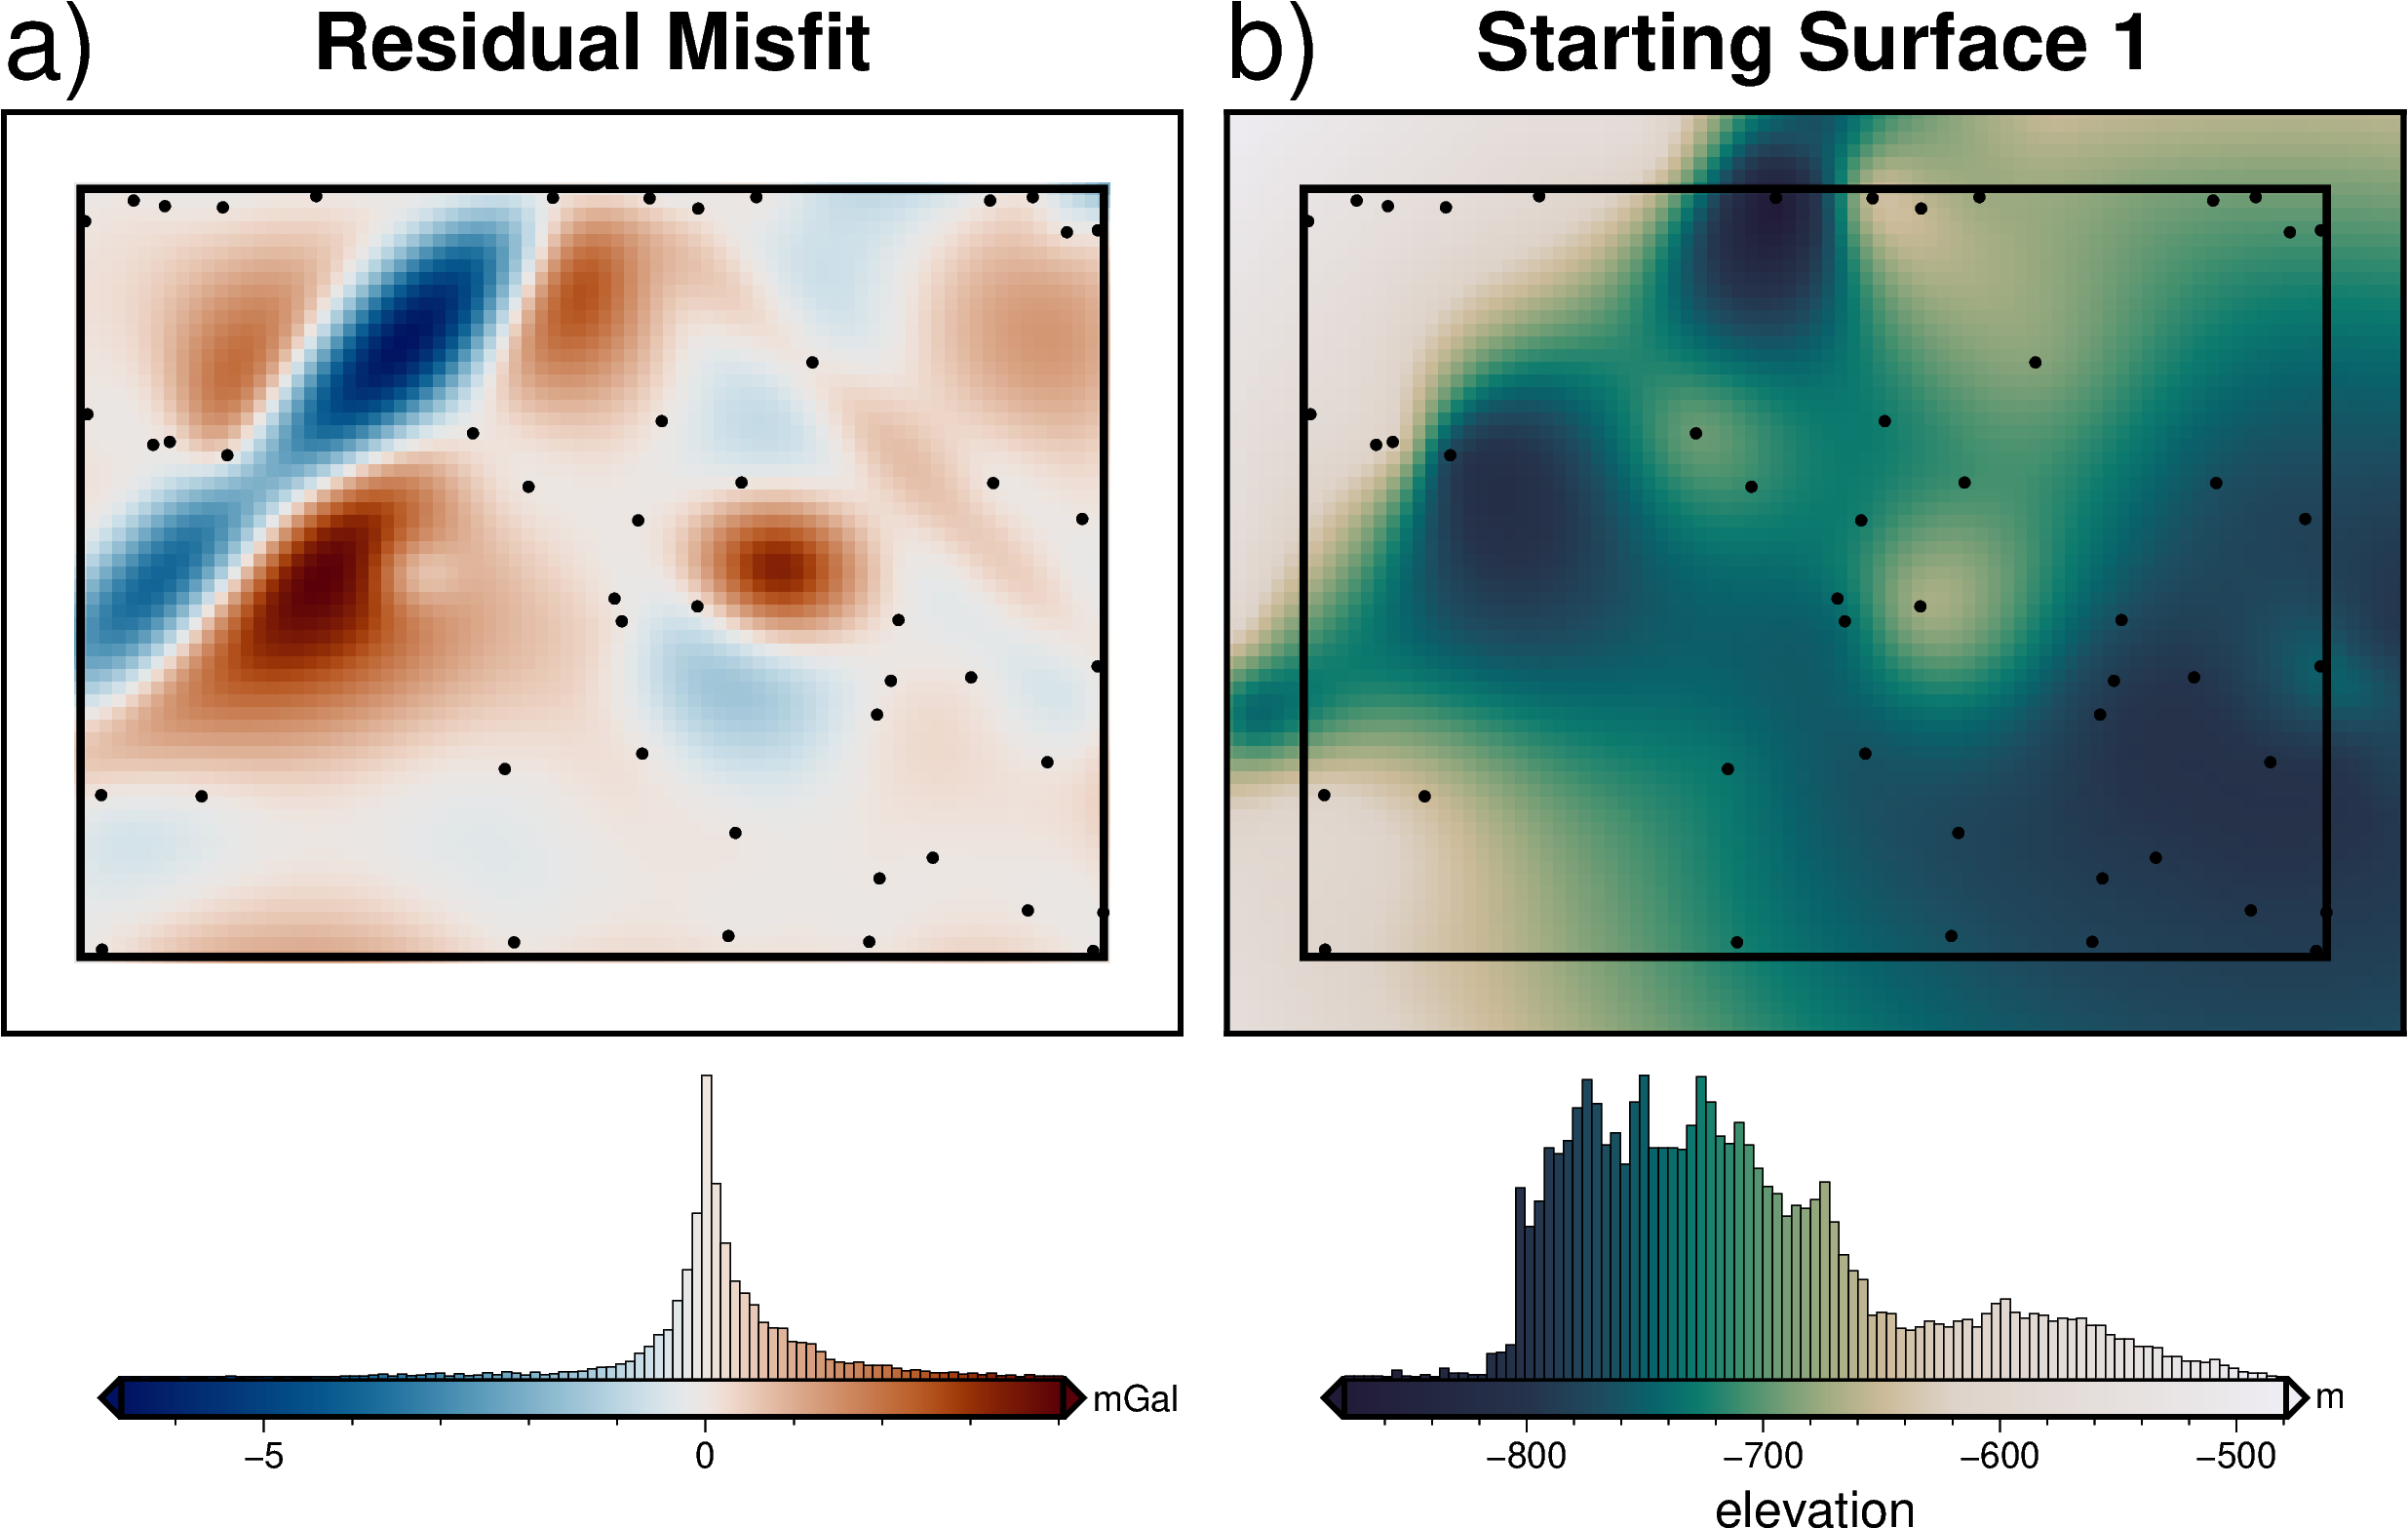

In [22]:
residual = df_anomalies.set_index(["northing", "easting"]).to_xarray().res
# residual.plot(robust=True)

# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


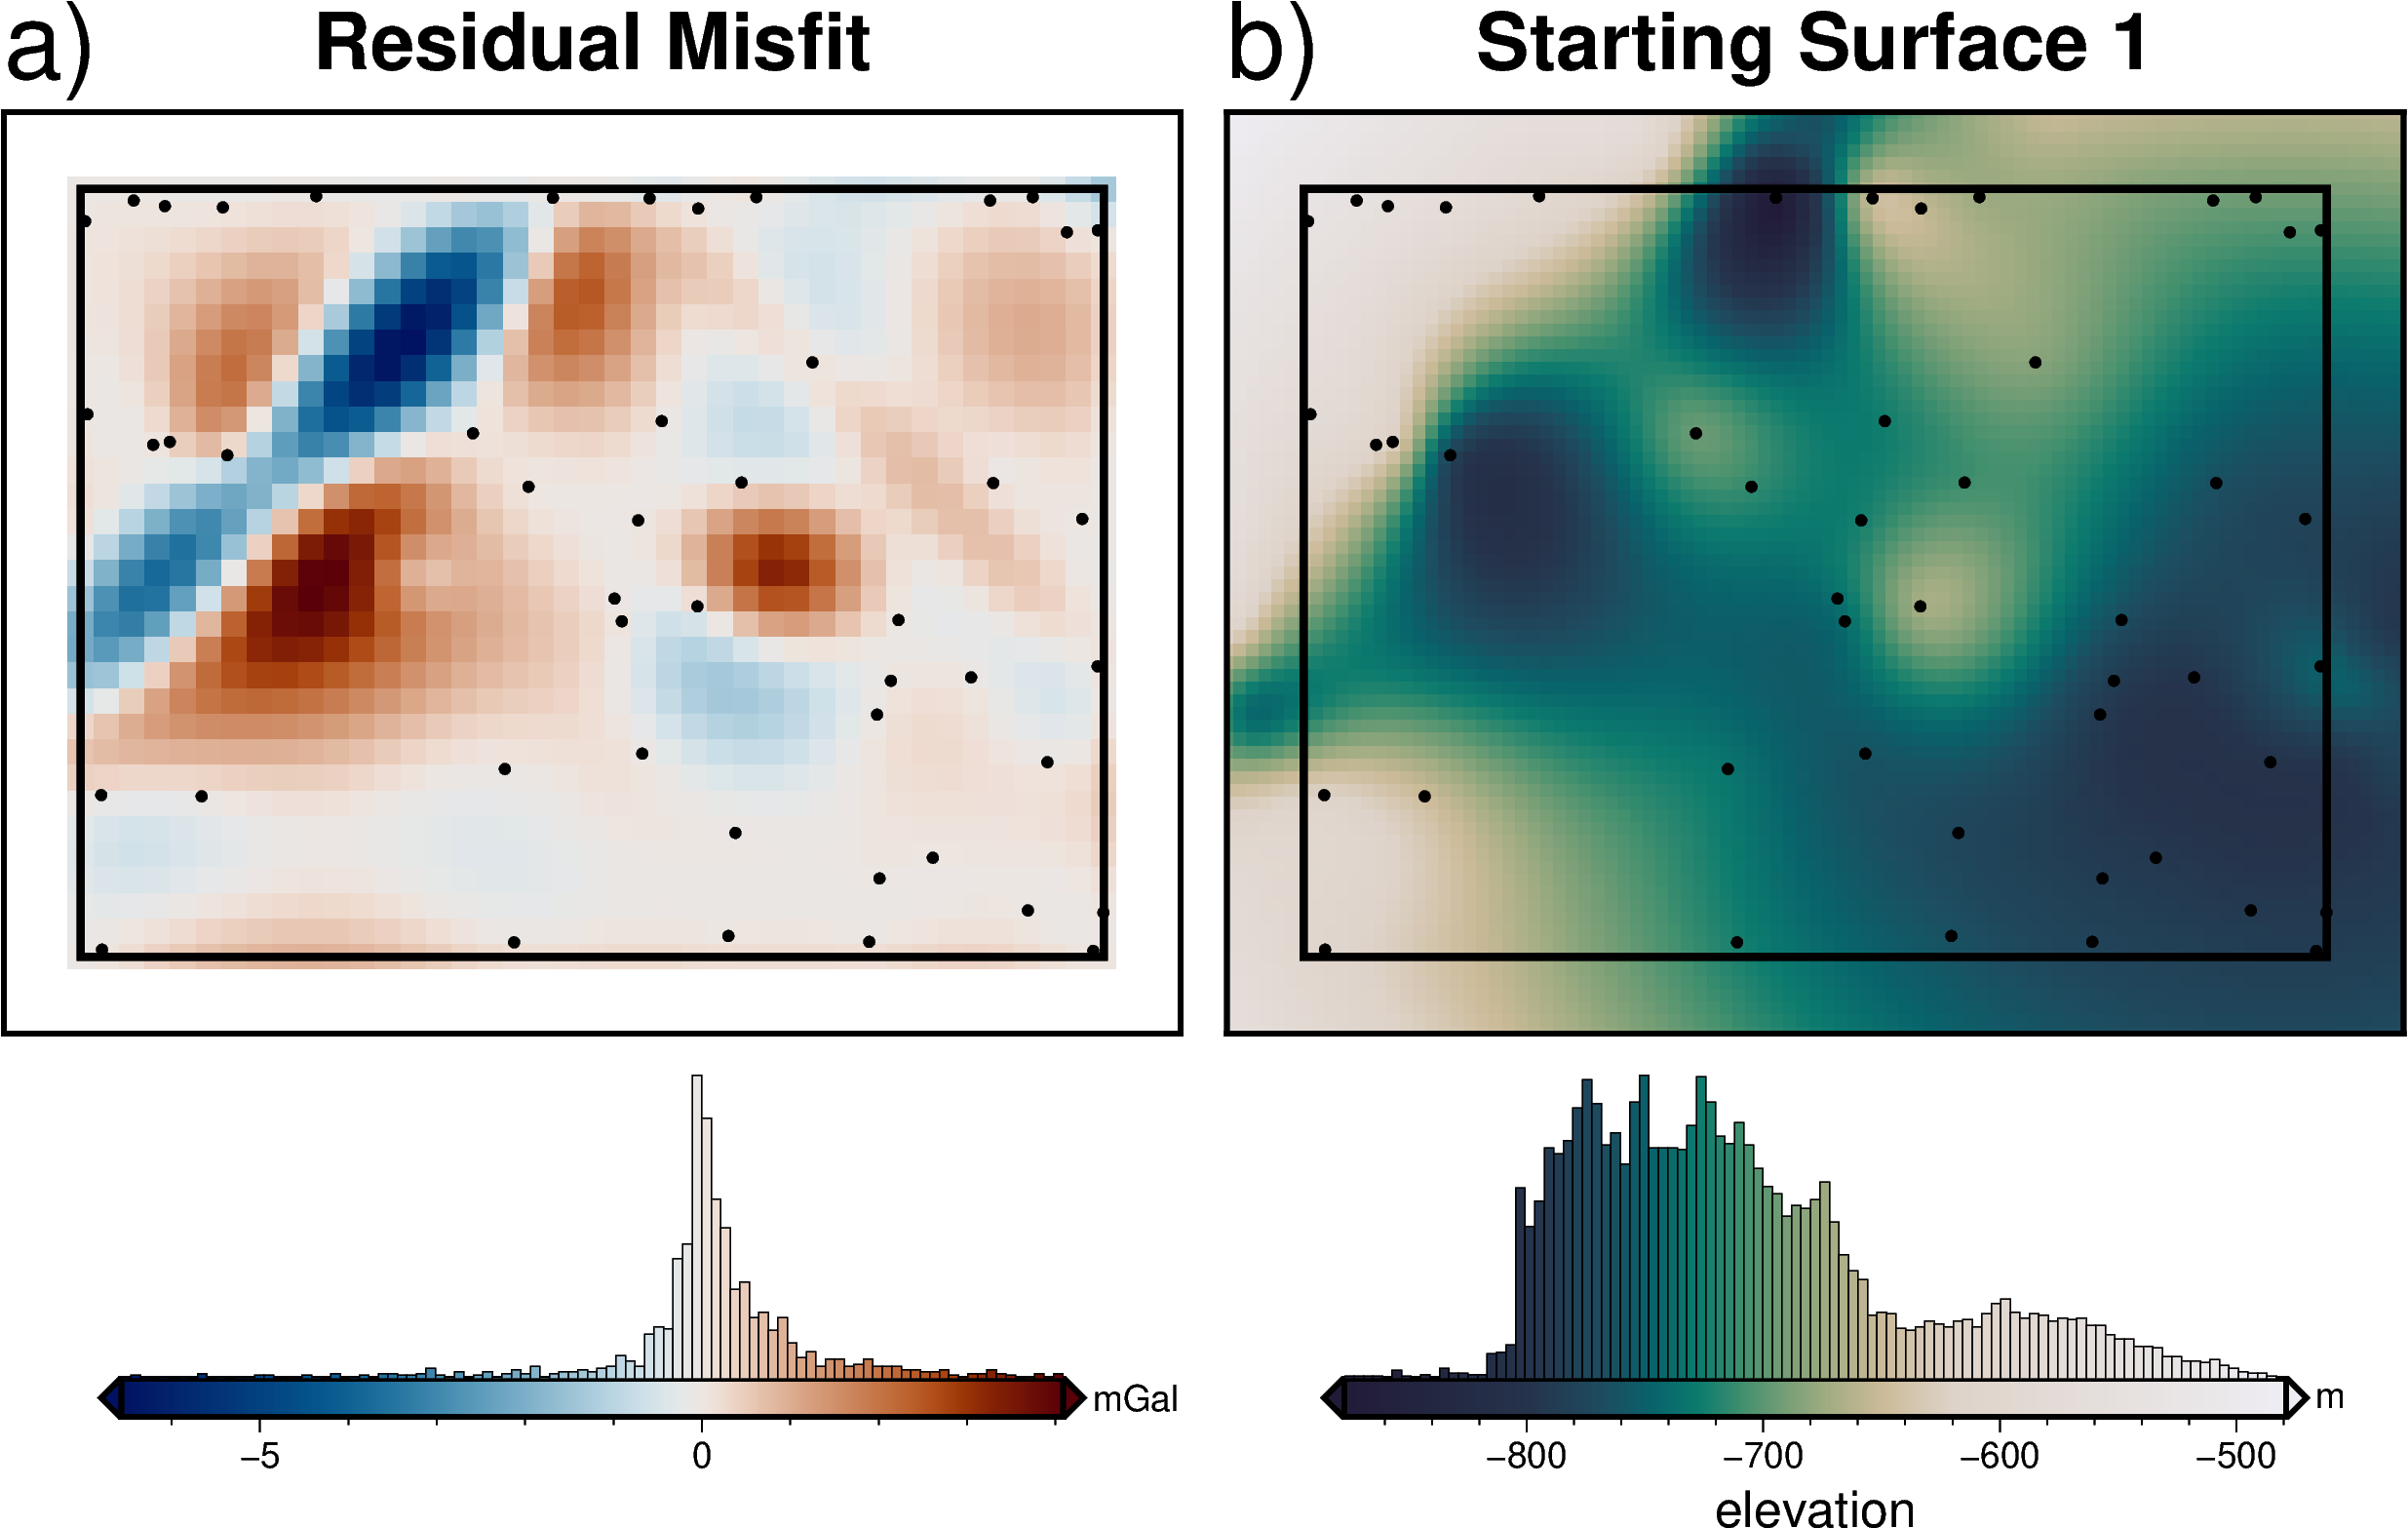

In [23]:
residual = df_anomalies_sampled.set_index(["northing", "easting"]).to_xarray().res
# residual.plot(robust=True)

# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. Theres a number of parameters to choose from for the inversion.

In [ ]:
# # set kwargs for inversion
# kwargs = dict(
#     input_grav_column="Gobs_shift",
#     prism_layer=starting_prisms,
#     max_iterations=200,
#     l2_norm_tolerance=0.01,
#     delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
#     # apply_weights = True,
#     weights_after_solving = True,
#     deriv_type = "annulus",
#     solver_type = "scipy least squares",
#     solver_damping = 10**-3,   
# )

# results = inv.inversion_RMSE(
    
#     # input_grav=df_anomalies,
#     input_grav=df_anomalies_sampled,

#     inversion_region=inversion_region,
#     true_surface = layer1,
#     constraints=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
#     plot=True,
#     plot_type="xarray",
#     **kwargs,
# )

# (
#     rmse,
#     prism_results,
#     grav_results,
#     params,
#     elapsed_time,
#     constraints_rmse,
# ) = results

# _ = plotting.plot_inversion_results(
#         grav_results,
#         prism_results,
#         params,
#         grav_region=inversion_region,
#         plot_iter_results=True,
#         plot_topo_results=True,
#         plot_grav_results=True,
#         iters_to_plot=4,
    
#         # grav_spacing=grav_spacing,
#         grav_spacing=sampled_grav_spacing,
    
#         constraints=constraint_points,
#     )

# print(f"RMSE: {rmse}")
# print(f"constraints RMSE: {constraints_rmse}")

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [ ]:

# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=200,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_inversion_damping_weights_with_border"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))


In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 20e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

## Repeat with sampled data

In [ ]:
# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies_sampled,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=200,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_inversion_damping_weights_with_border"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [ ]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )
    

In [ ]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

# Repeat with noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [25]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise["res"] = synthetic.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

northing  easting  Surface1  Surface2      Gobs  upward  layer1_forward  \
0          0.0      0.0  4.895946 -1.585934  3.310012  1000.0        4.918955   
1          0.0   1000.0  4.764286 -1.697236  3.067050  1000.0        4.798930   
2          0.0   2000.0  4.616825 -1.806994  2.809832  1000.0        4.665710   
3          0.0   3000.0  4.458949 -1.915200  2.543749  1000.0        4.523598   
4          0.0   4000.0  4.294071 -2.021884  2.272188  1000.0        4.373681   
...        ...      ...       ...       ...       ...     ...             ...   
4936   60000.0  76000.0  0.829439  8.586936  9.416375  1000.0        0.851258   
4937   60000.0  77000.0  0.825047  8.508668  9.333715  1000.0        0.843413   
4938   60000.0  78000.0  0.822520  8.397605  9.220126  1000.0        0.838053   
4939   60000.0  79000.0  0.821311  8.246703  9.068014  1000.0        0.834626   
4940   60000.0  80000.0  0.820536  8.046806  8.867341  1000.0        0.832120   

      Gobs_shift    misfit        reg       res  
0       4.134998 -0.783957  -0.610214  0.061871  
1       3.892036 -0.906894  -0.850257 -0.001377  
2       3.634818 -1.030892  -1.090757  0.191633  
3       3.368735 -1.154863  -1.332658  0.476464  
4       3.097174 -1.276507  -1.572278  0.545072  
...          ...       ...        ...       ...  
4936   10.241361  9.390102  10.025627 -0.679420  
4937   10.158701  9.315287  10.282646 -1.053710  
4938   10.045112  9.207059  10.511027 -1.428115  
4939    9.893000  9.058374  10.712048 -1.572259  
4940    9.692328  8.860207  10.902406 -2.100254  

[4941 rows x 11 columns]

In [26]:
df_anomalies_sampled_noise = df_anomalies_sampled.copy()

df_anomalies_sampled_noise["res"] = synthetic.contaminate(
    df_anomalies_sampled_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_sampled_noise

northing  easting  upward      Gobs  layer1_forward  Gobs_shift  \
0          0.0      0.0  1000.0  3.310012        4.918955    4.135921   
1          0.0   2000.0  1000.0  2.809832        4.665710    3.635741   
2          0.0   4000.0  1000.0  2.272187        4.373681    3.098096   
3          0.0   6000.0  1000.0  1.720770        4.050939    2.546679   
4          0.0   8000.0  1000.0  1.166181        3.704710    1.992090   
...        ...      ...     ...       ...             ...         ...   
1266   60000.0  72000.0  1000.0  9.534210        0.911332   10.360119   
1267   60000.0  74000.0  1000.0  9.510522        0.874972   10.336431   
1268   60000.0  76000.0  1000.0  9.416374        0.851258   10.242283   
1269   60000.0  78000.0  1000.0  9.220125        0.838053   10.046034   
1270   60000.0  80000.0  1000.0  8.867341        0.832120    9.693250   

        misfit        reg       res  
0    -0.783034  -0.683803  0.135089  
1    -1.029969  -1.085204  0.110427  
2    -1.275584  -1.490370  0.345967  
3    -1.504261  -1.881671  0.674357  
4    -1.712620  -2.248453  0.783748  
...        ...        ...       ...  
1266  9.448787   9.584212 -0.340624  
1267  9.461459   9.600059  0.158703  
1268  9.391025   9.807156 -0.600355  
1269  9.207981  10.025845 -0.562756  
1270  8.861130  10.184242 -1.598255  

[1271 rows x 9 columns]

## Plot inversion inputs

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


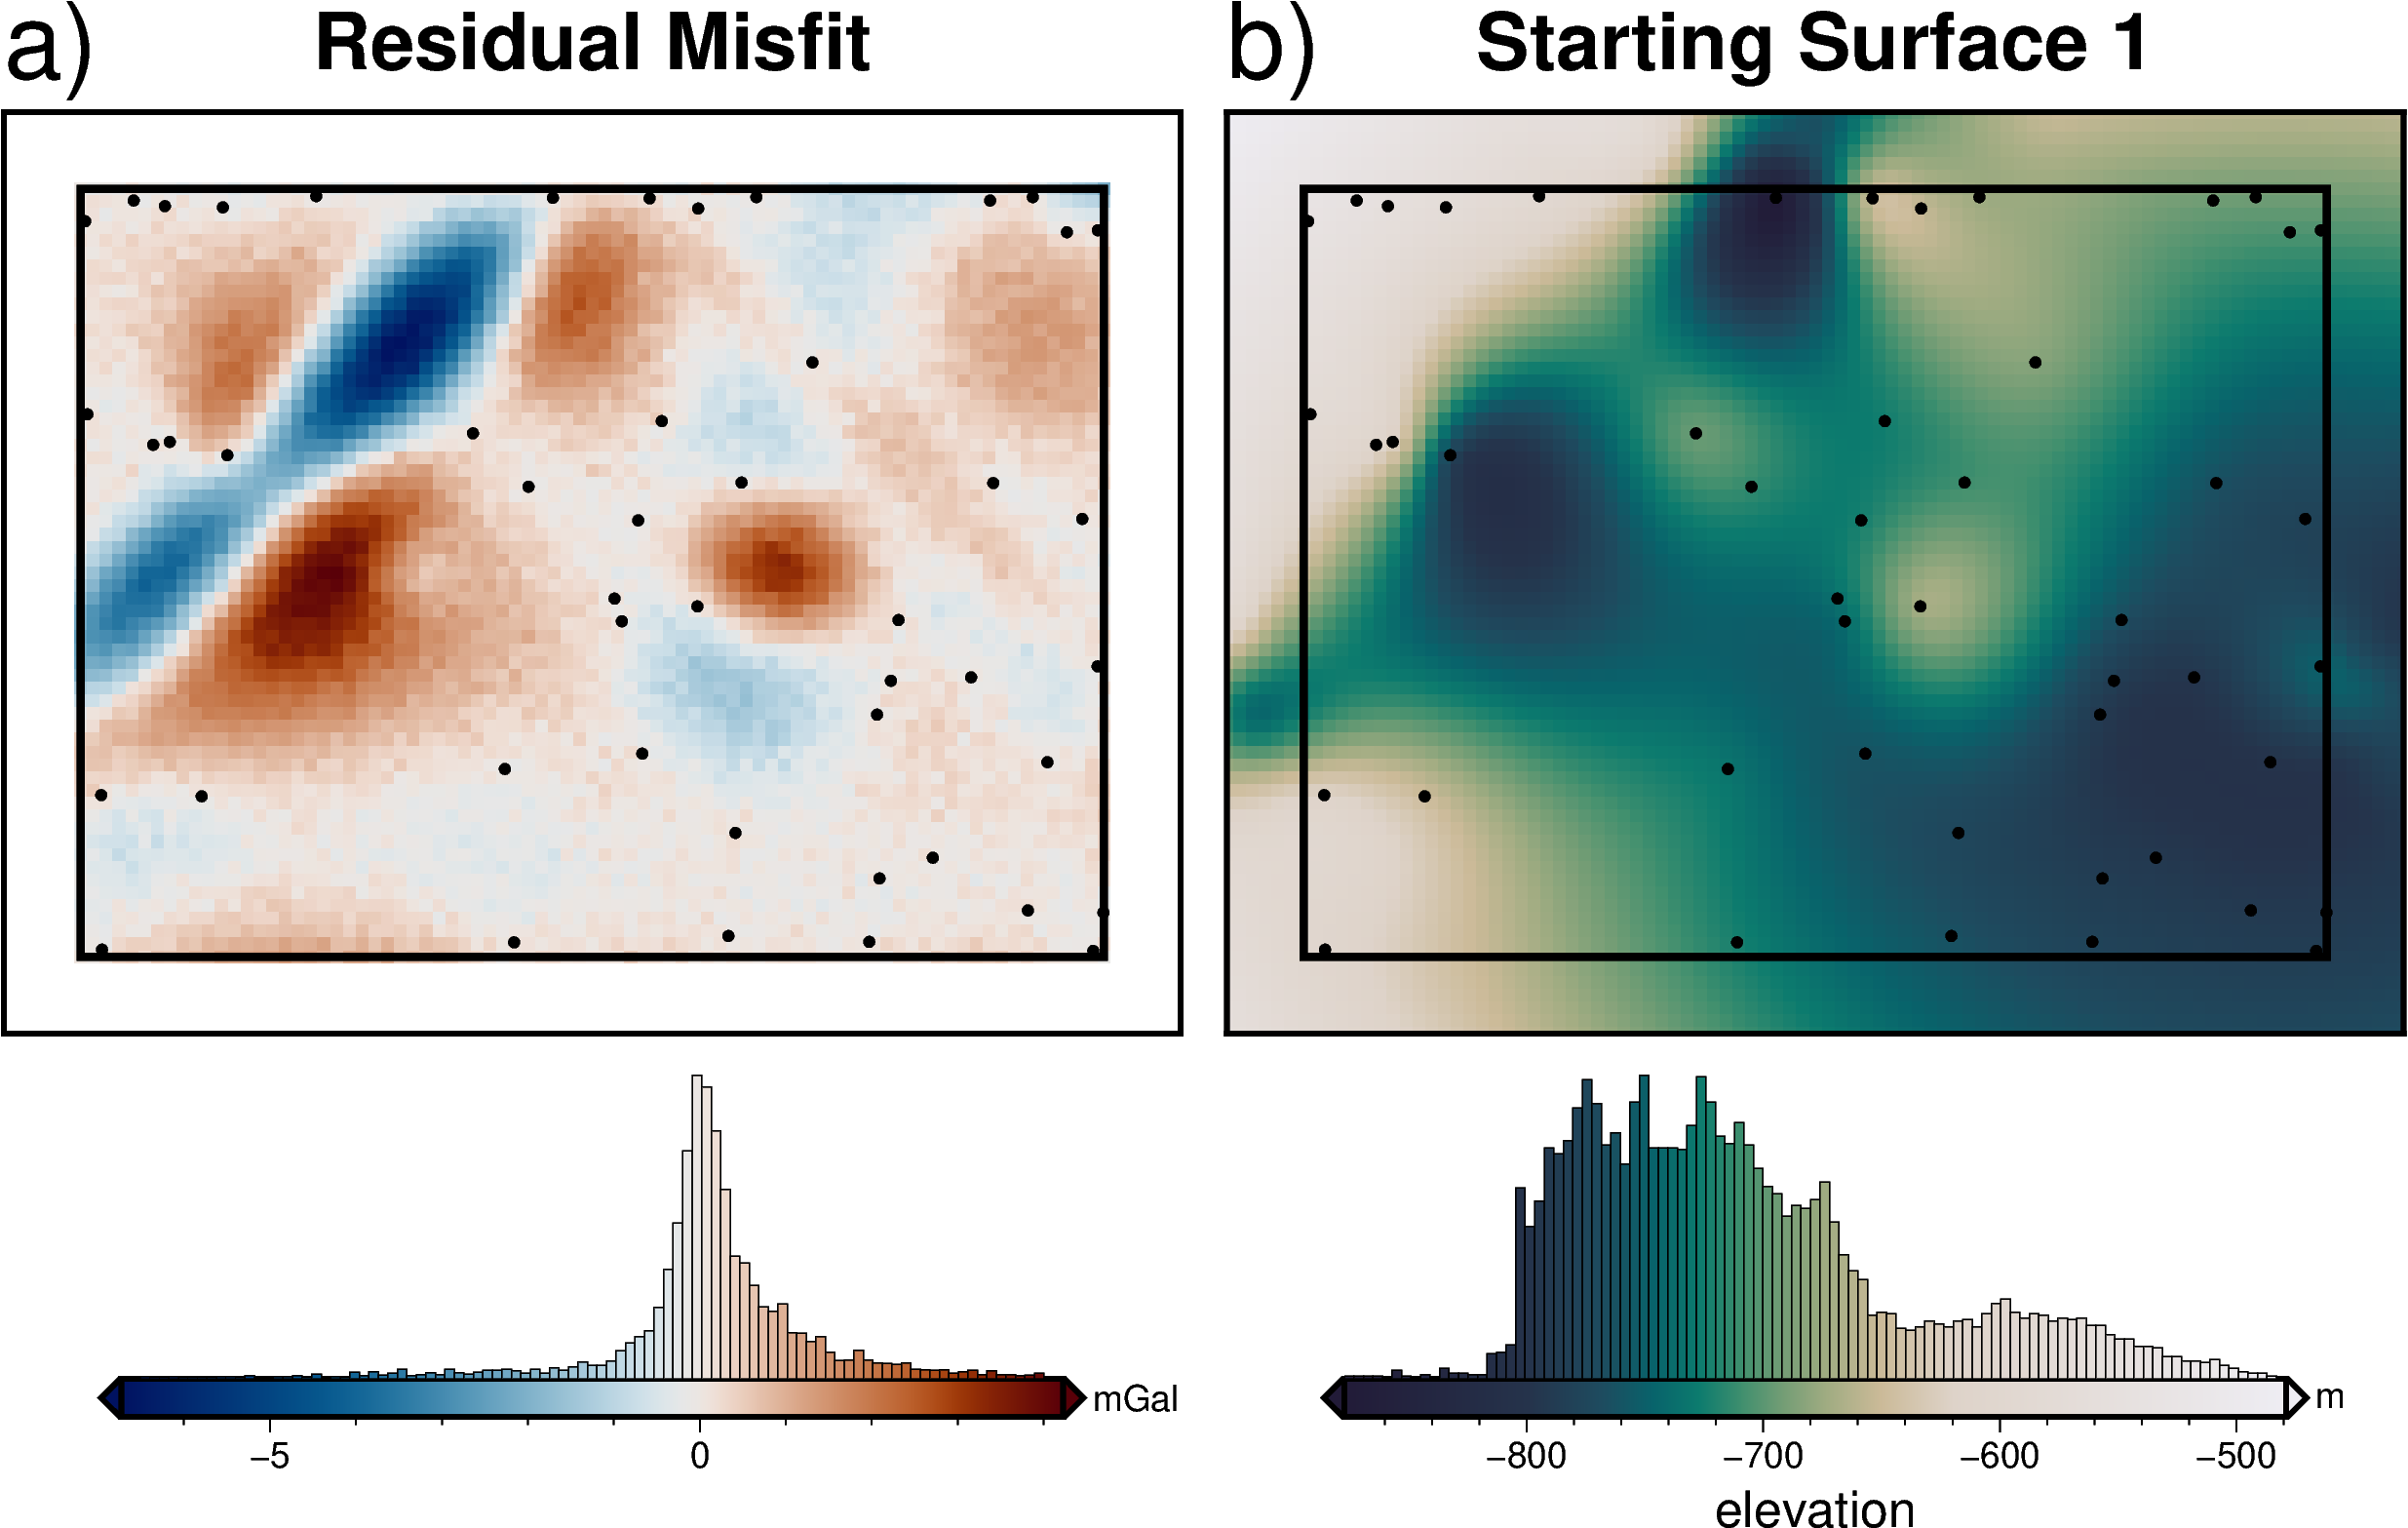

In [27]:
residual = df_anomalies_noise.set_index(["northing", "easting"]).to_xarray().res
# residual.plot(robust=True)

# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

returning grid with new region and/or registration, same spacing


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


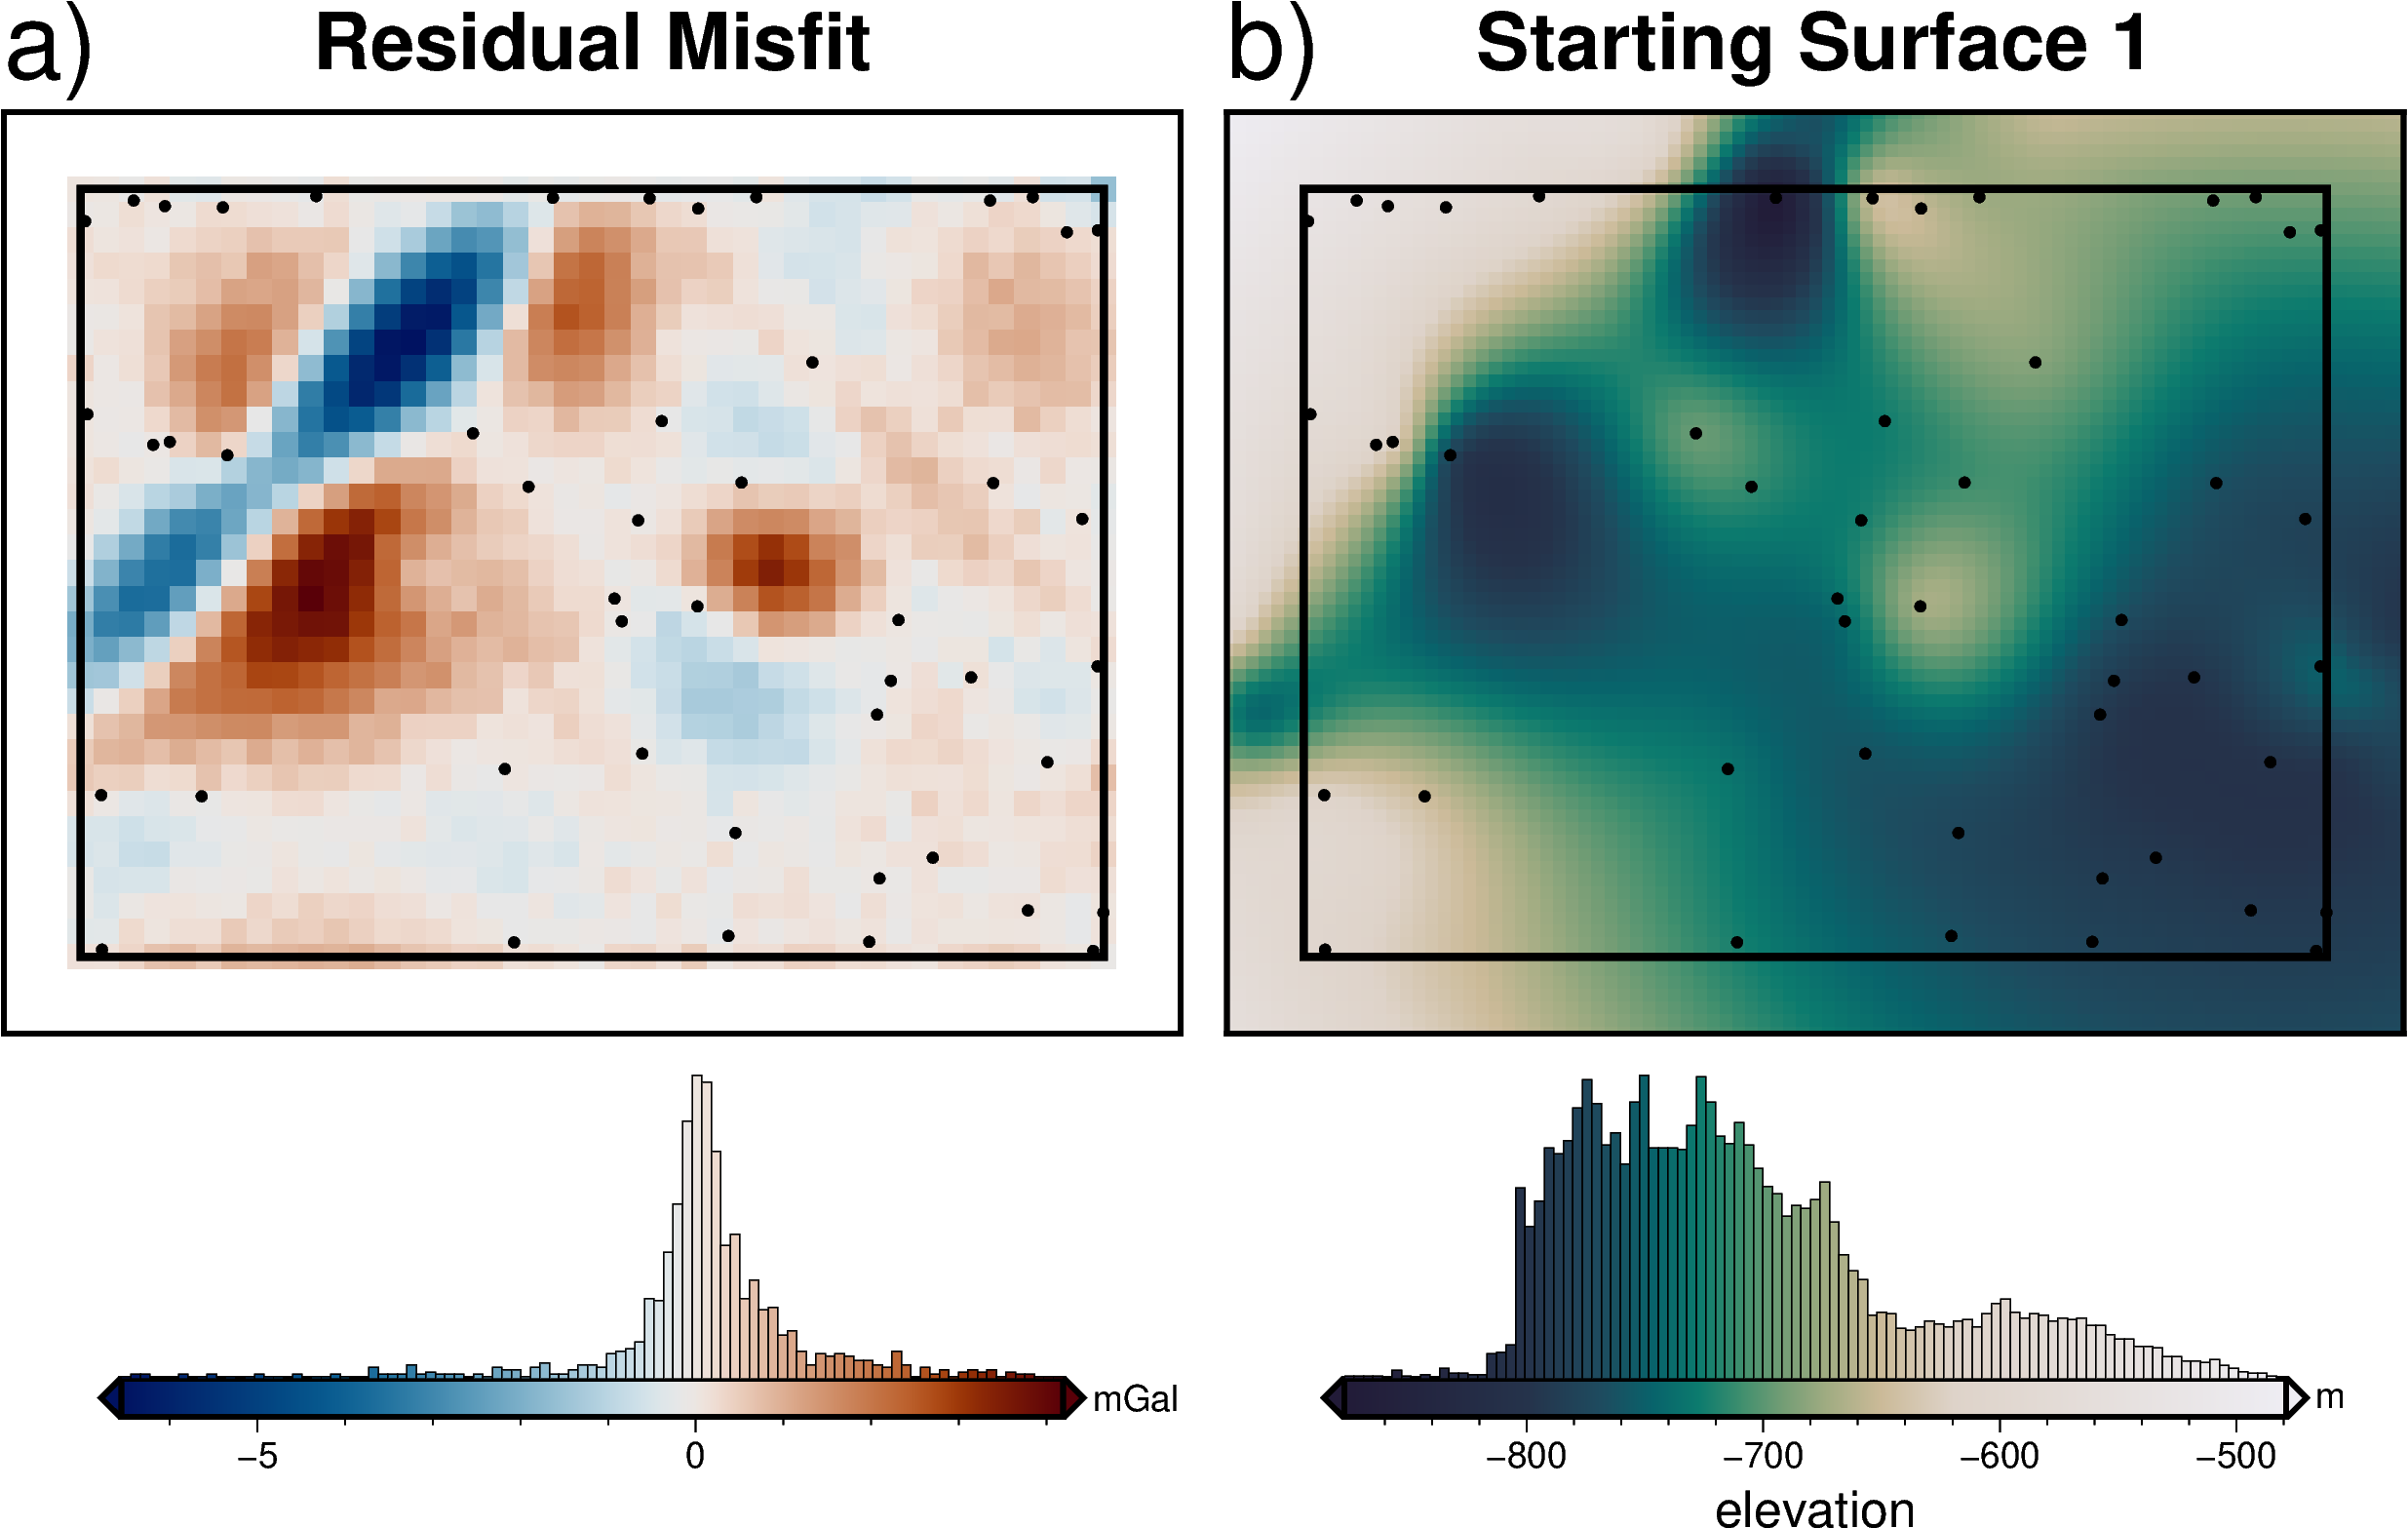

In [28]:
residual = df_anomalies_sampled_noise.set_index(["northing", "easting"]).to_xarray().res
# residual.plot(robust=True)

# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position="TL",
    justify="BL",
    text="a)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer1,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 1",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="c0.1c",
)
fig.text(
    position="TL",
    justify="BL",
    text="b)",
    font="26p,Helvetica,black",
    offset="j0/.3",
    no_clip=True,
)

fig.show()

## Optimize the inversion

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Solver damping

In [56]:

# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies_noise,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=200,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_inversion_damping_weights_with_border_noise"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))


In [57]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 20e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = optimization.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
        parallel=True,
    )

[I 2023-04-16 11:42:25,515] A new study created in Journal with name: synthetic_simple_inversion_damping_weights_with_border_noise


Optimizing:   0%|          | 0/50 [00:00<?, ?it/s]

FrozenTrial(number=37, state=TrialState.COMPLETE, values=[5.186943882199785], datetime_start=datetime.datetime(2023, 4, 16, 11, 42, 37, 273466), datetime_complete=datetime.datetime(2023, 4, 16, 11, 53, 52, 64795), params={'damping': -1, 'weights_outer': 4000}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=20000, log=False, low=2000, step=100)}, trial_id=37, value=None)


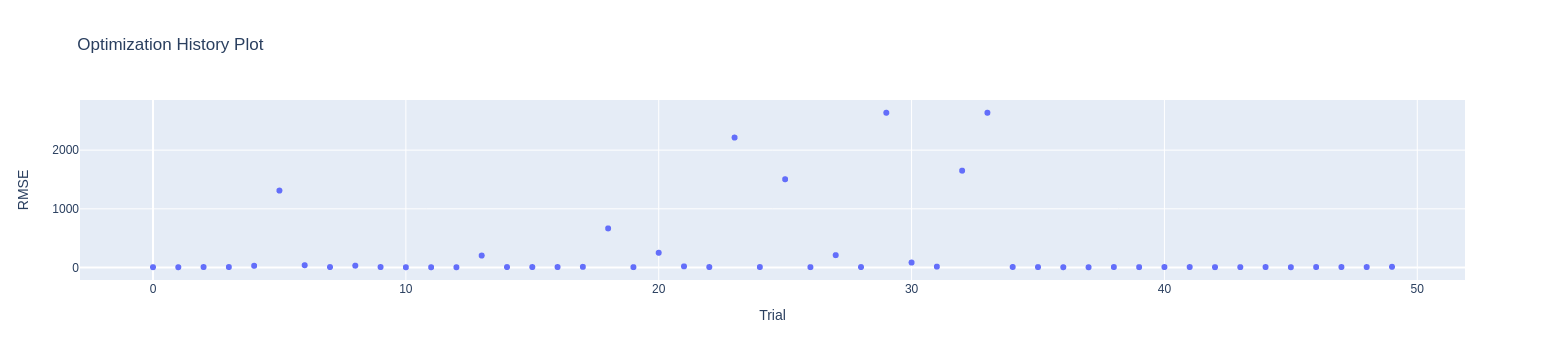

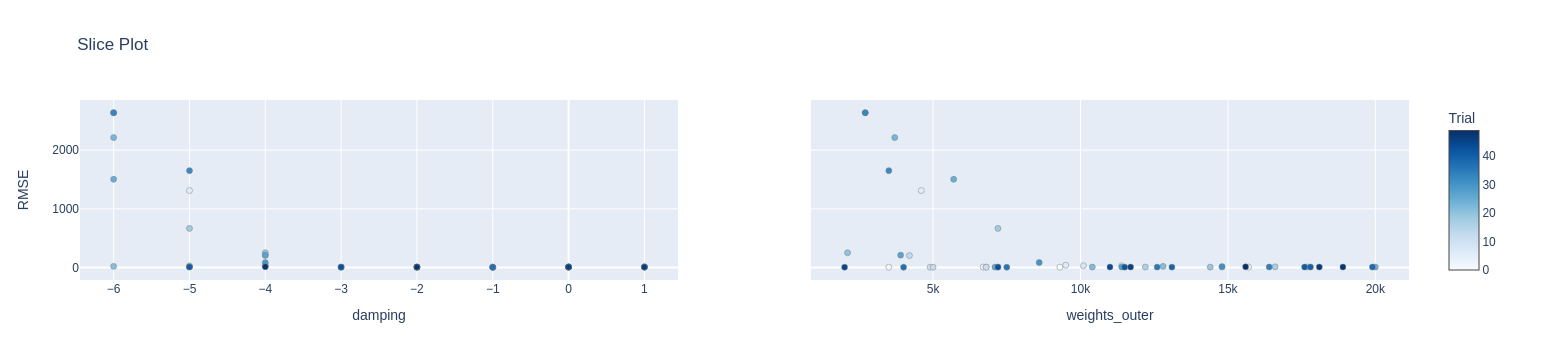

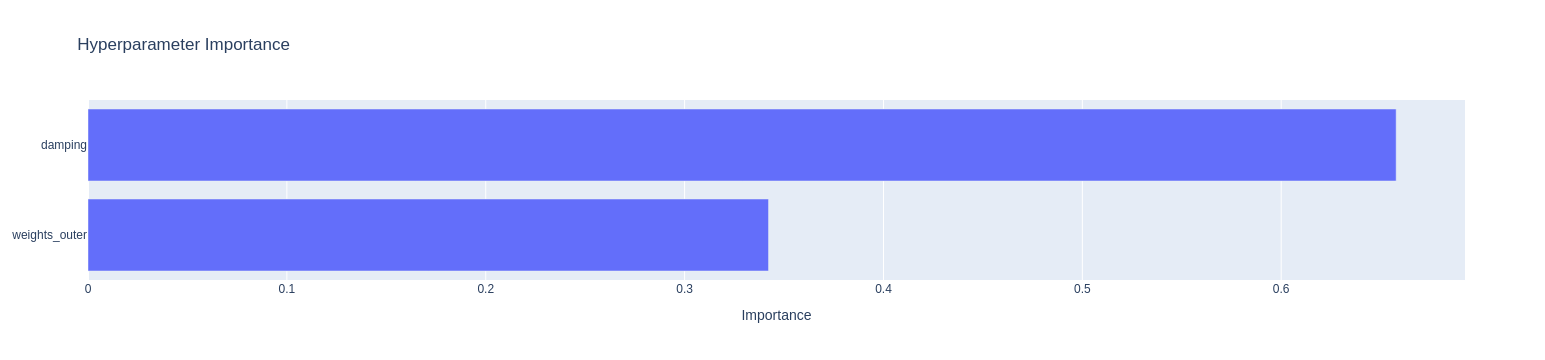

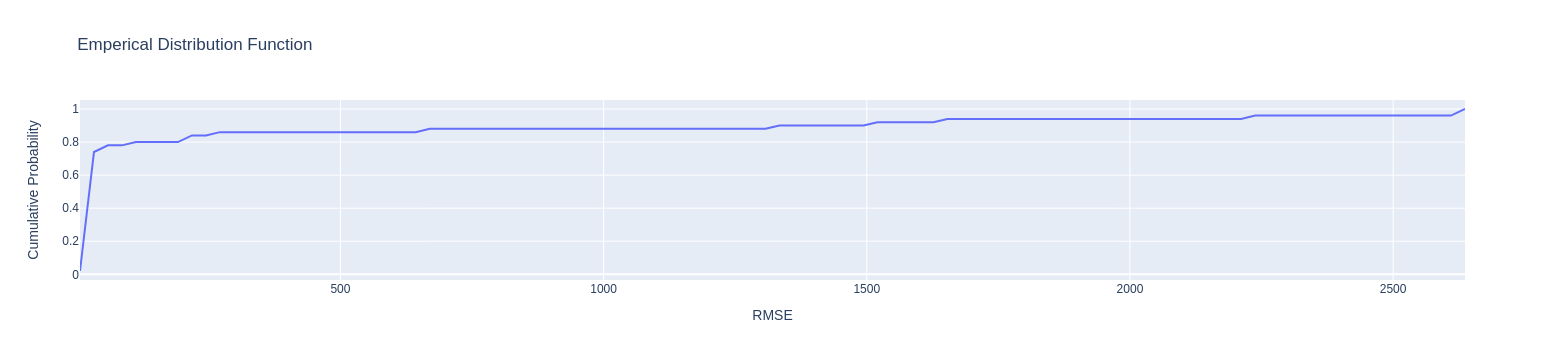

In [58]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)
print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

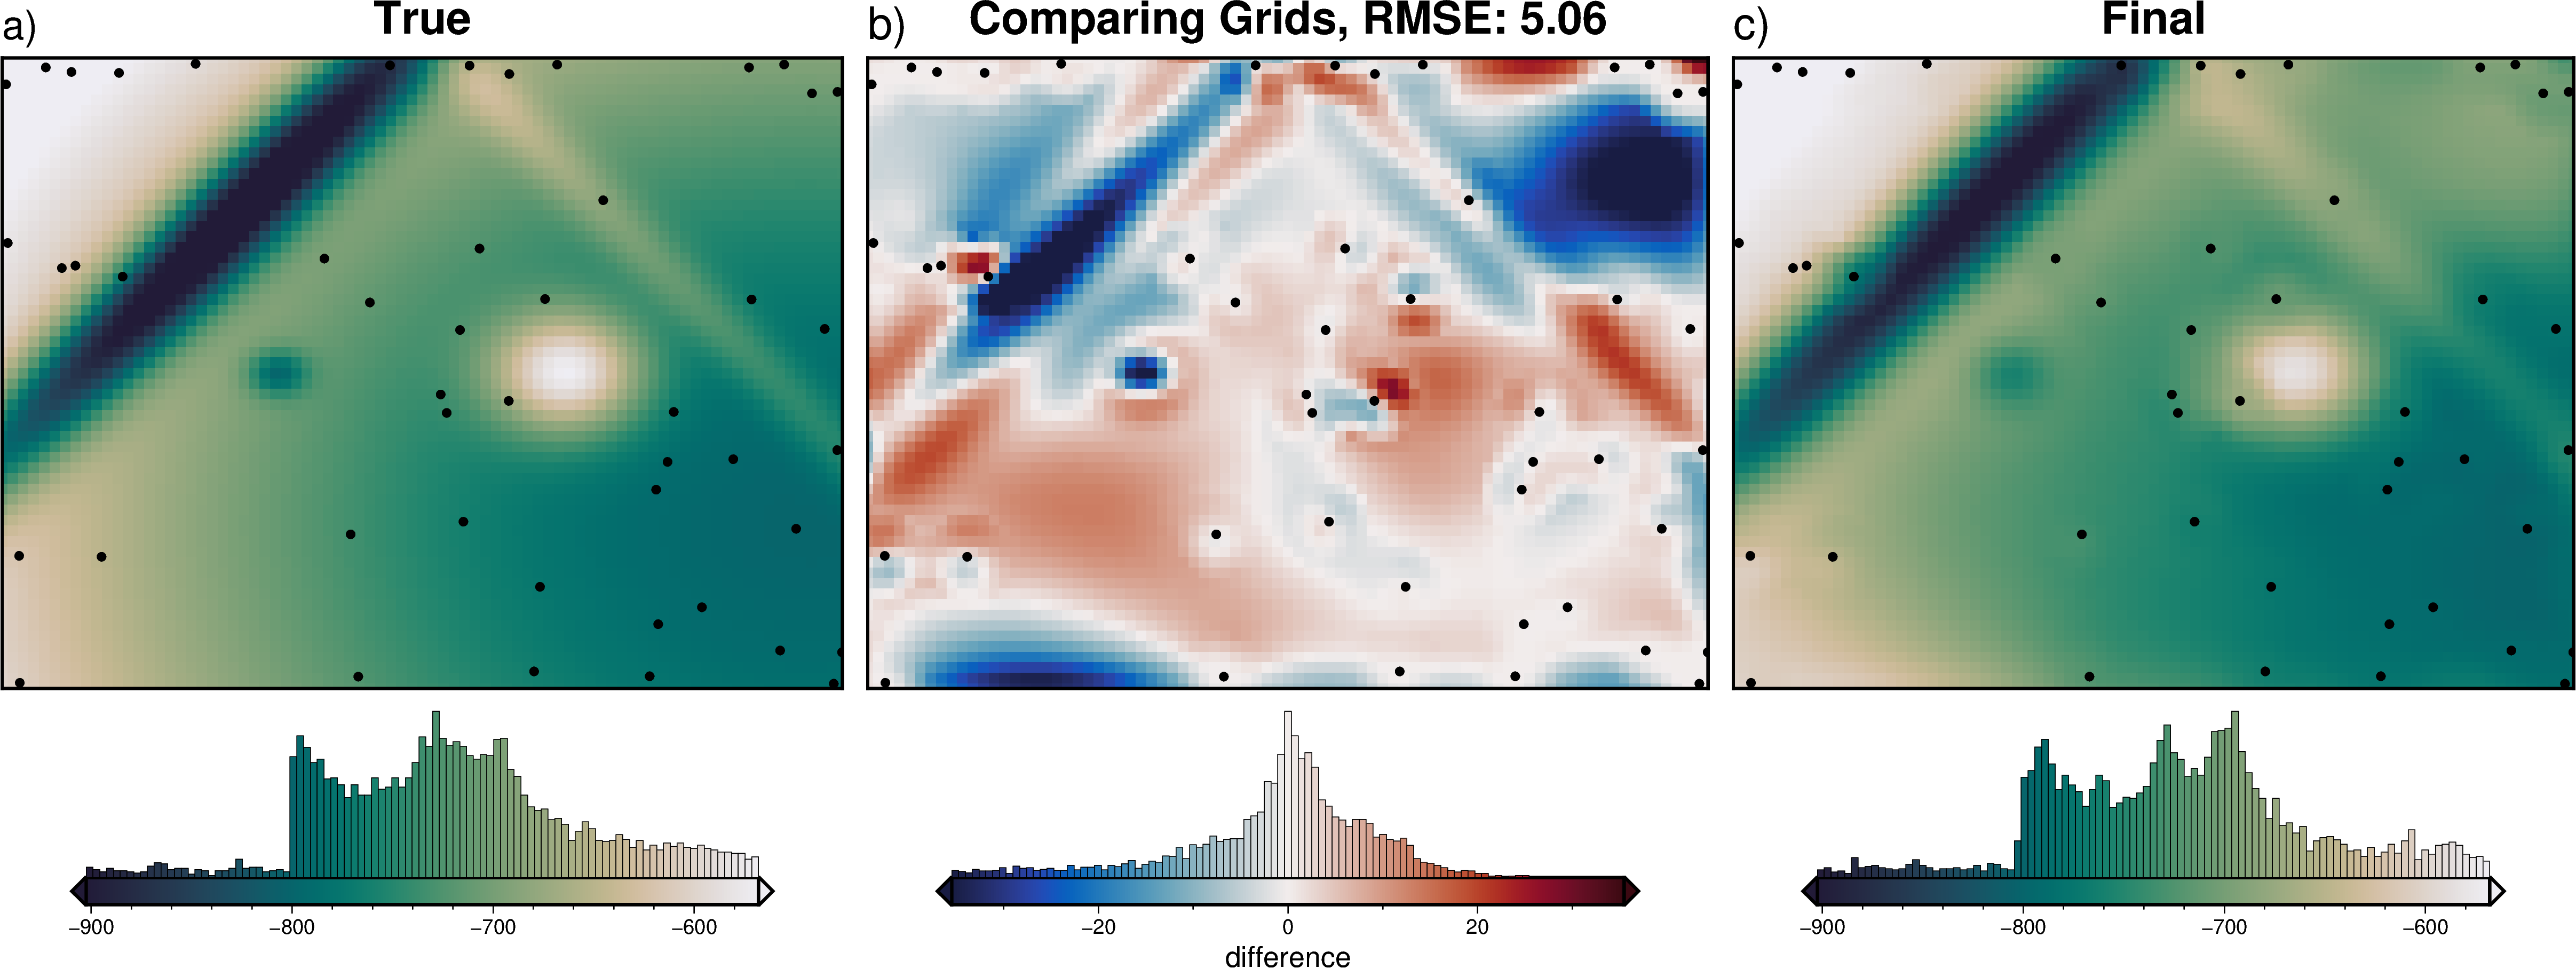

RMSE between surfaces at constraints: 0.1 m


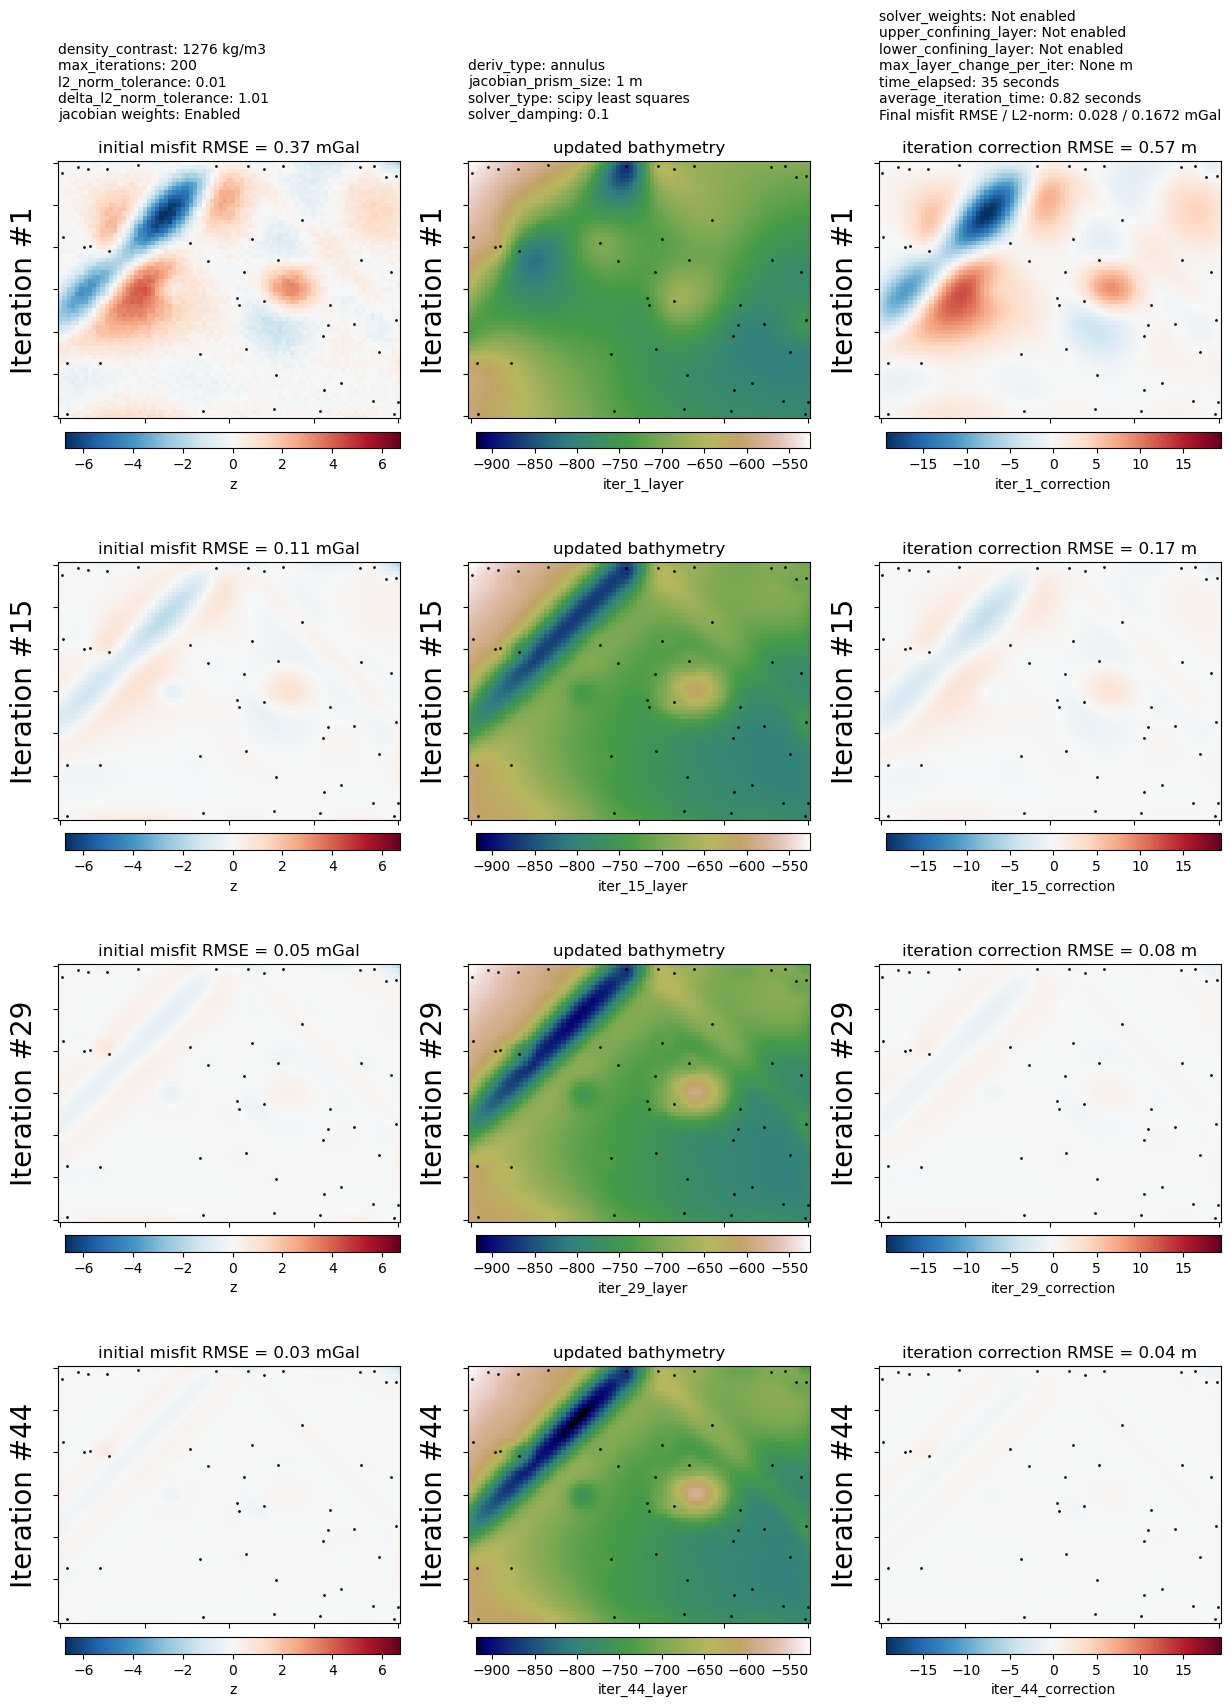

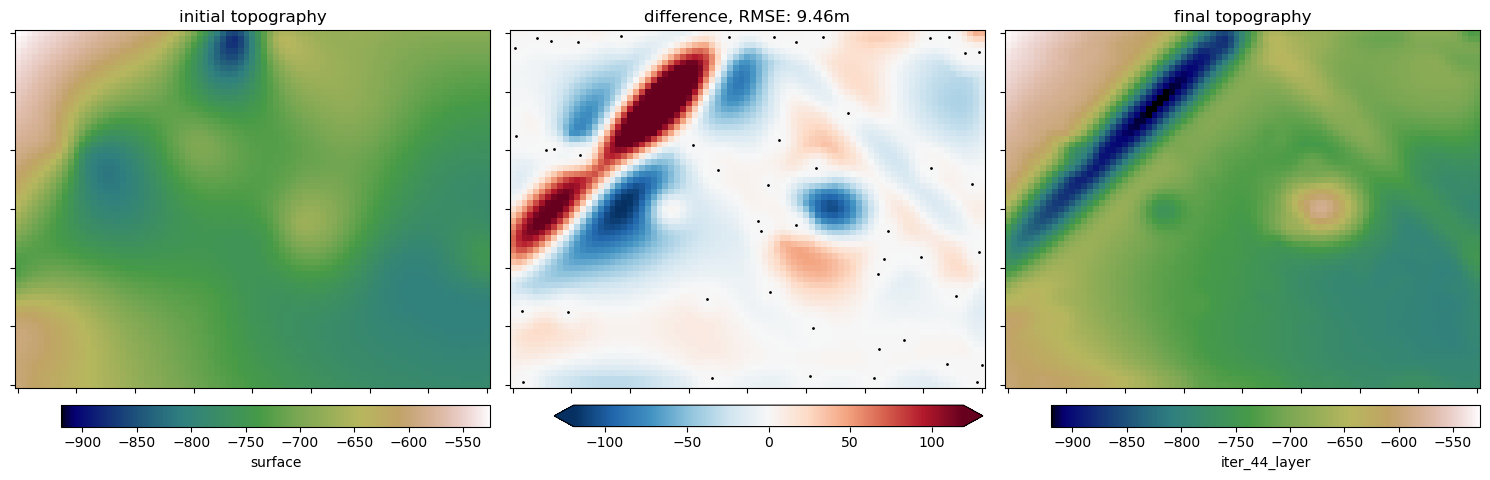

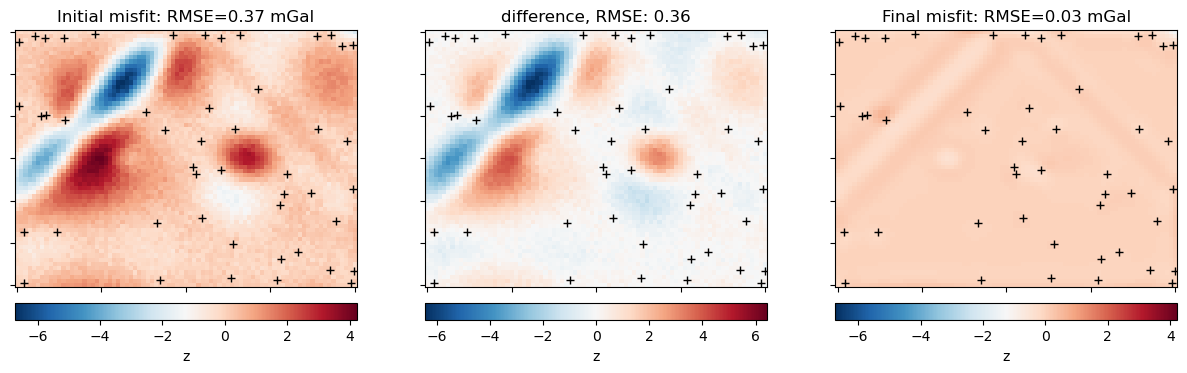

In [59]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

## Repeat with sampled data

In [29]:
# set kwargs for inversion
kwargs = dict(
    input_grav=df_anomalies_sampled_noise,
    input_grav_column="Gobs_shift",
    # prism_layer=starting_prisms,
    inversion_region=inversion_region,
    max_iterations=200,
    l2_norm_tolerance=0.01,
    delta_l2_norm_tolerance=1.01, # stop if l2-norm doesnt decrease by at least 1%
    # apply_weights = True,
    weights_after_solving = True,
    deriv_type = "annulus",
    solver_type = "scipy least squares",
)

# set name and storage for the optimization
study_name = "synthetic_simple_sampled_inversion_damping_weights_with_border_noise"
fname = f"../optimization_logs/{study_name}.log"

# remove if exists
# pathlib.Path(fname).unlink(missing_ok=True)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="JournalStorage is experimental")
    storage = JournalStorage(JournalFileStorage(fname))

In [30]:
# set number of runs
n_trials = 50

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions = [
    "minimize"
    # "minimize"
    # "minimize"
]

# define search space if using GridSampler
search_space = {
    "damping": np.arange(-6, 1, step=1, dtype="float"),
    # "weights_inner": np.arange(1e3, 1900, step=100),
    "weights_outer": np.arange(2e3, 20e3, step=2e3, dtype="float"),
}
# create study
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="BoTorch")
    study = optuna.create_study(
        study_name=study_name,
        storage=storage,
        directions=directions,
        # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
        # sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
        sampler=optuna.samplers.GridSampler(search_space),
        load_if_exists=True,
        )

# define the objective function
objective_func = optimization.optimal_inversion_damping_and_weights(
    layer1,
    damping_limits = [-6, 1], # damping = 10^damping_limit
    weights_inner_limits = [1e3],#[1e3, 1900],
    weights_outer_limits = [2e3, 15e3],
    weights_step = 100,
    starting_prisms = starting_prisms,
    objectives = objectives,
    constraints = constraint_points,
    **kwargs)

# objective_func = optimization.optimal_inversion_damping(
#     layer1,
#     damping_limits = [-10, 1], # damping = 10^damping_limit
#     objectives = objectives,
#     constraints = constraint_points,
#     **kwargs)

# run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = optimization.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#         parallel=True,
#     )
    

[I 2023-04-16 13:11:26,849] Using an existing study with name 'synthetic_simple_sampled_inversion_damping_weights_with_border_noise' instead of creating a new one.


FrozenTrial(number=43, state=TrialState.COMPLETE, values=[4.968132071745913], datetime_start=datetime.datetime(2023, 4, 16, 11, 56, 26, 996035), datetime_complete=datetime.datetime(2023, 4, 16, 11, 57, 33, 233569), params={'damping': -5, 'weights_outer': 6600}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'damping': IntDistribution(high=1, log=False, low=-6, step=1), 'weights_outer': IntDistribution(high=15000, log=False, low=2000, step=100)}, trial_id=43, value=None)


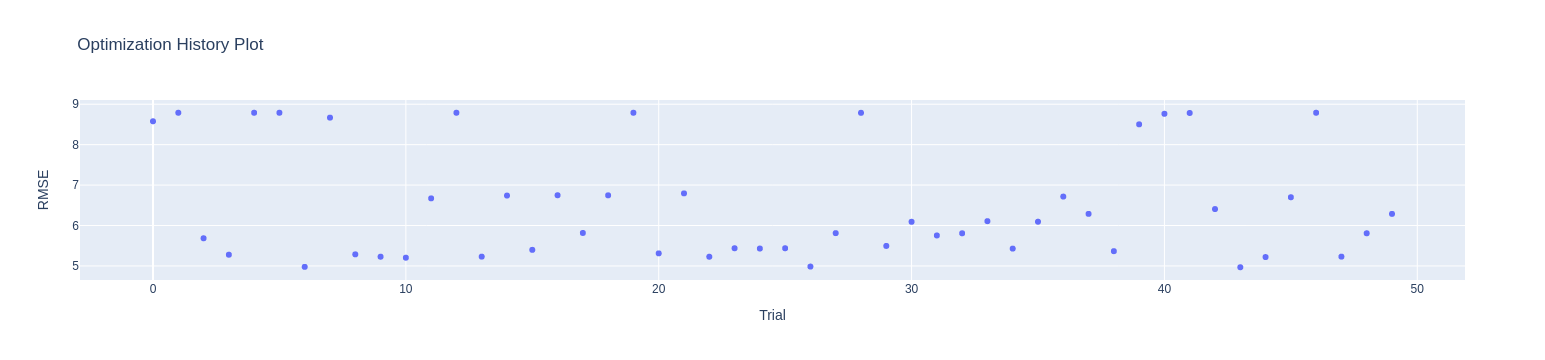

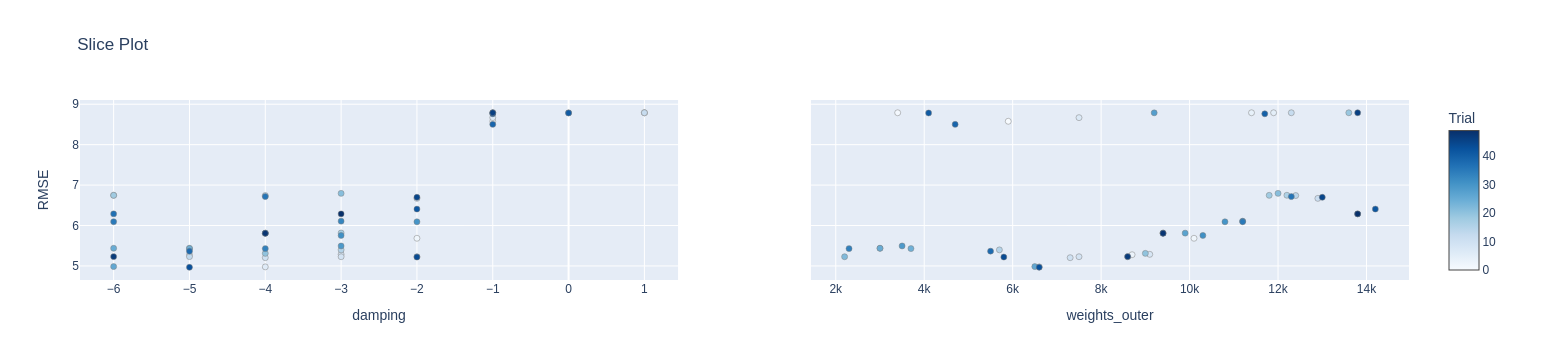

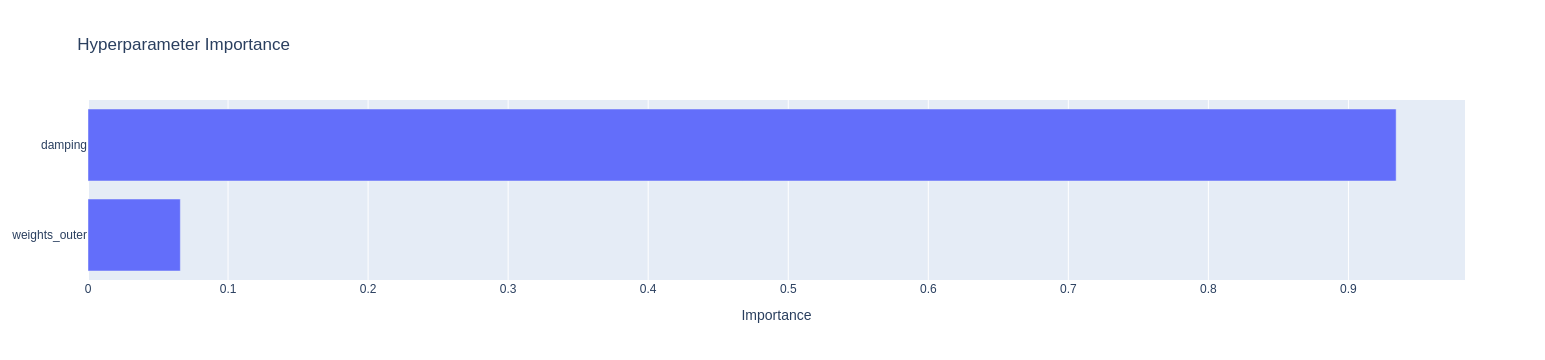

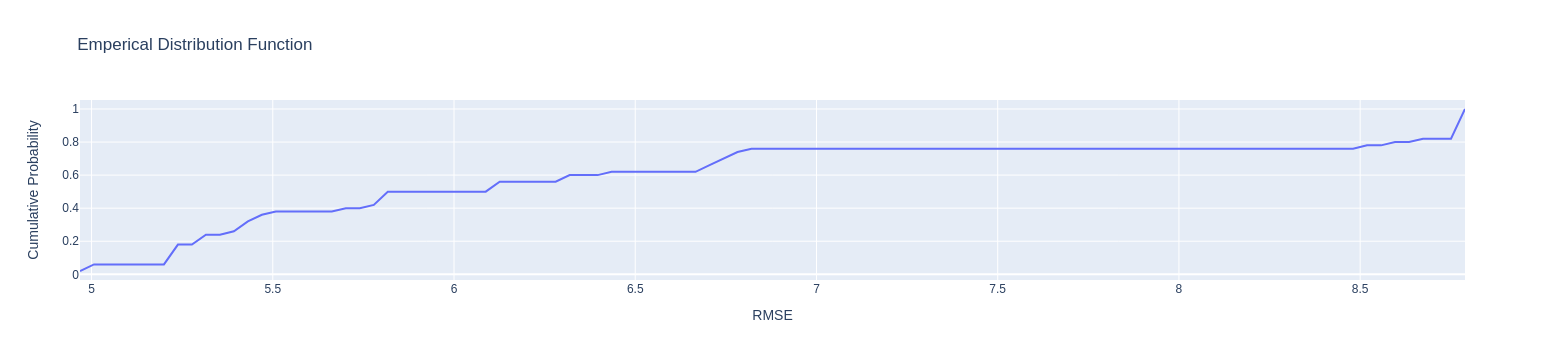

In [31]:
# load and plot past study
study = optuna.load_study(
    study_name=study_name,
    storage=storage,
)

print(study.best_trial)
plotting.plot_optuna_inversion_figures(
    study,
    target_names=objectives,
    # include_duration=True,
)

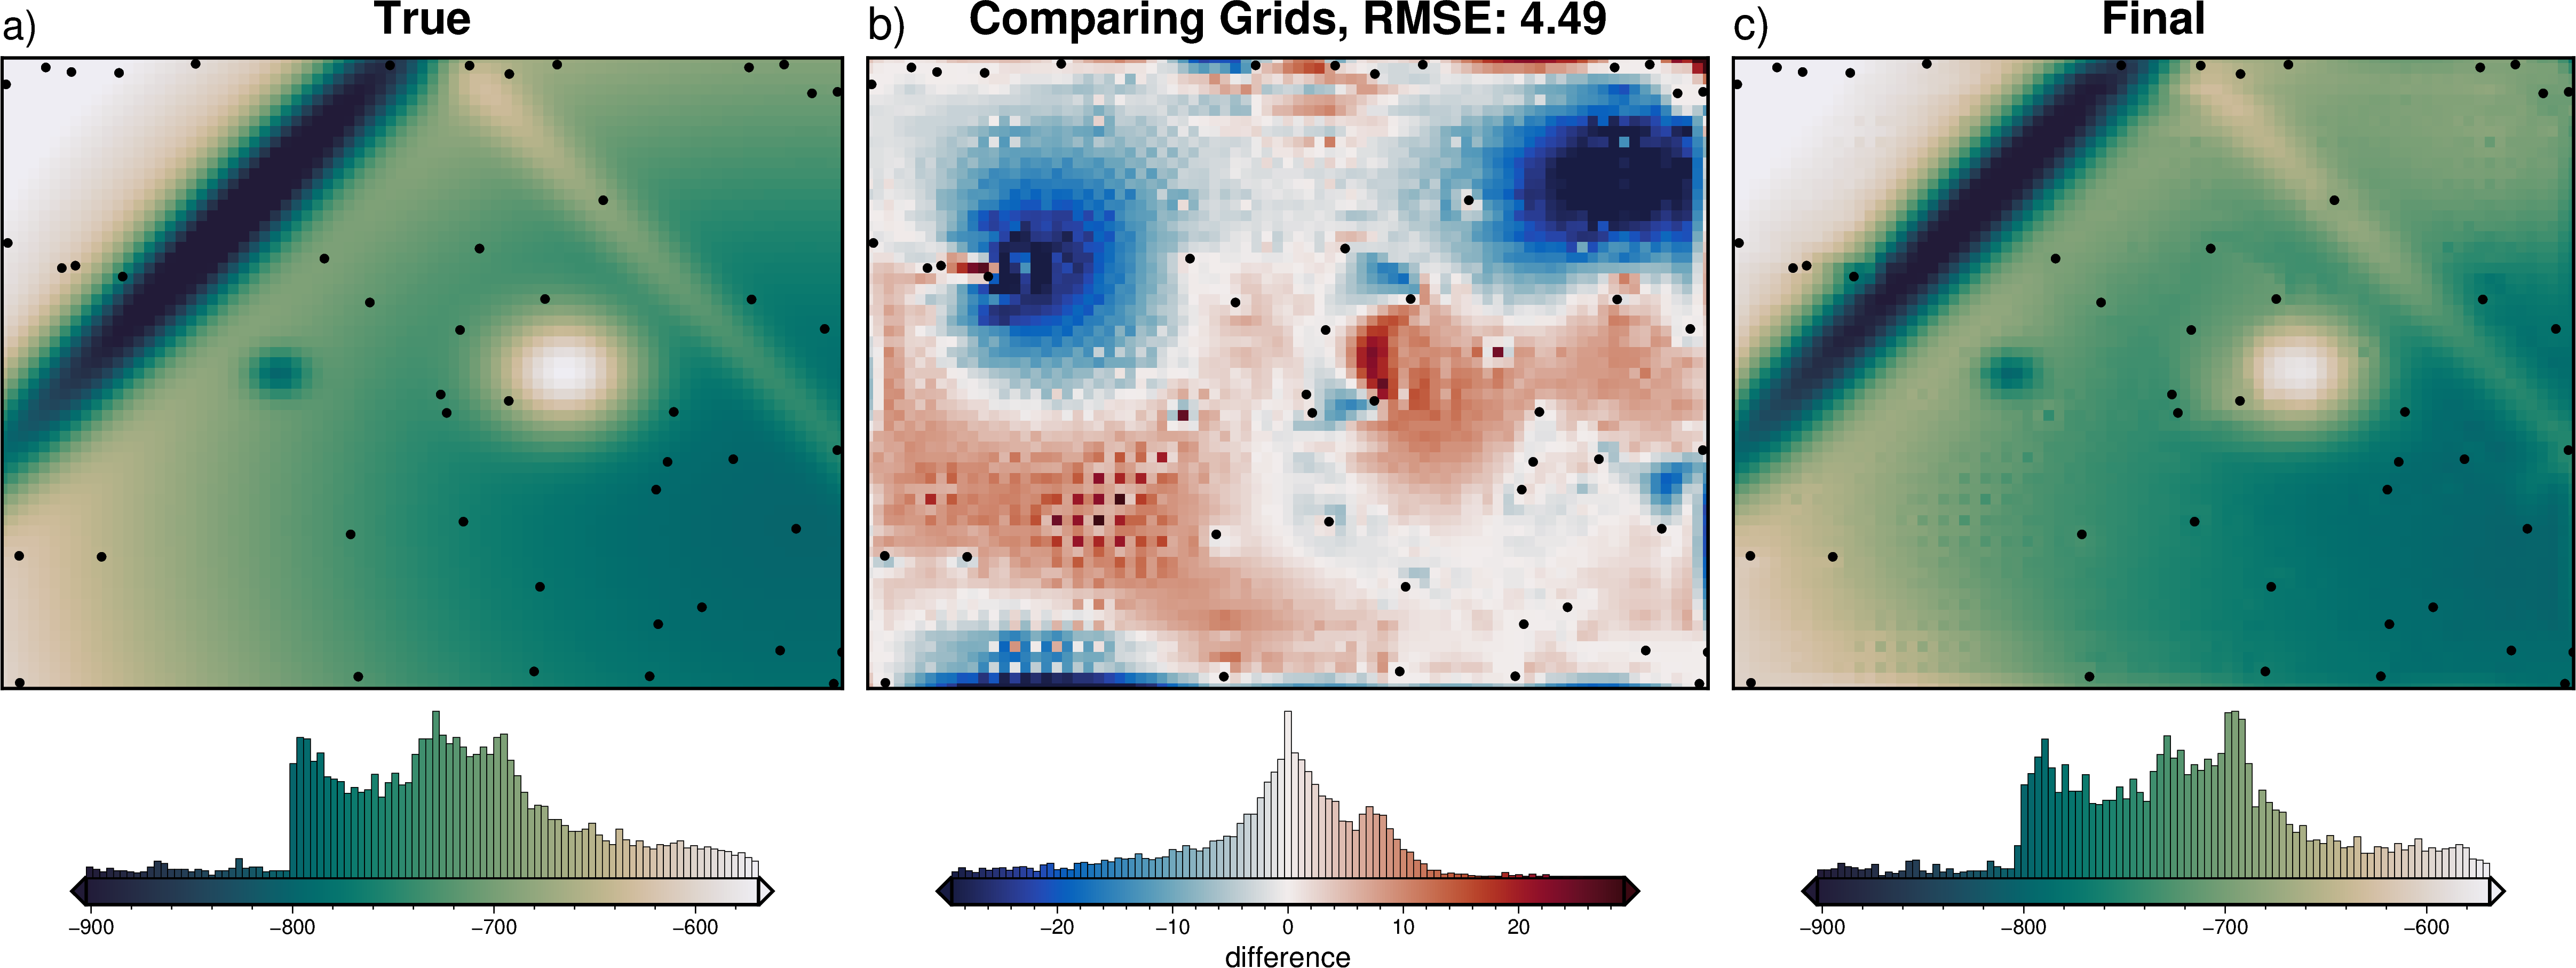

RMSE between surfaces at constraints: 0.21 m


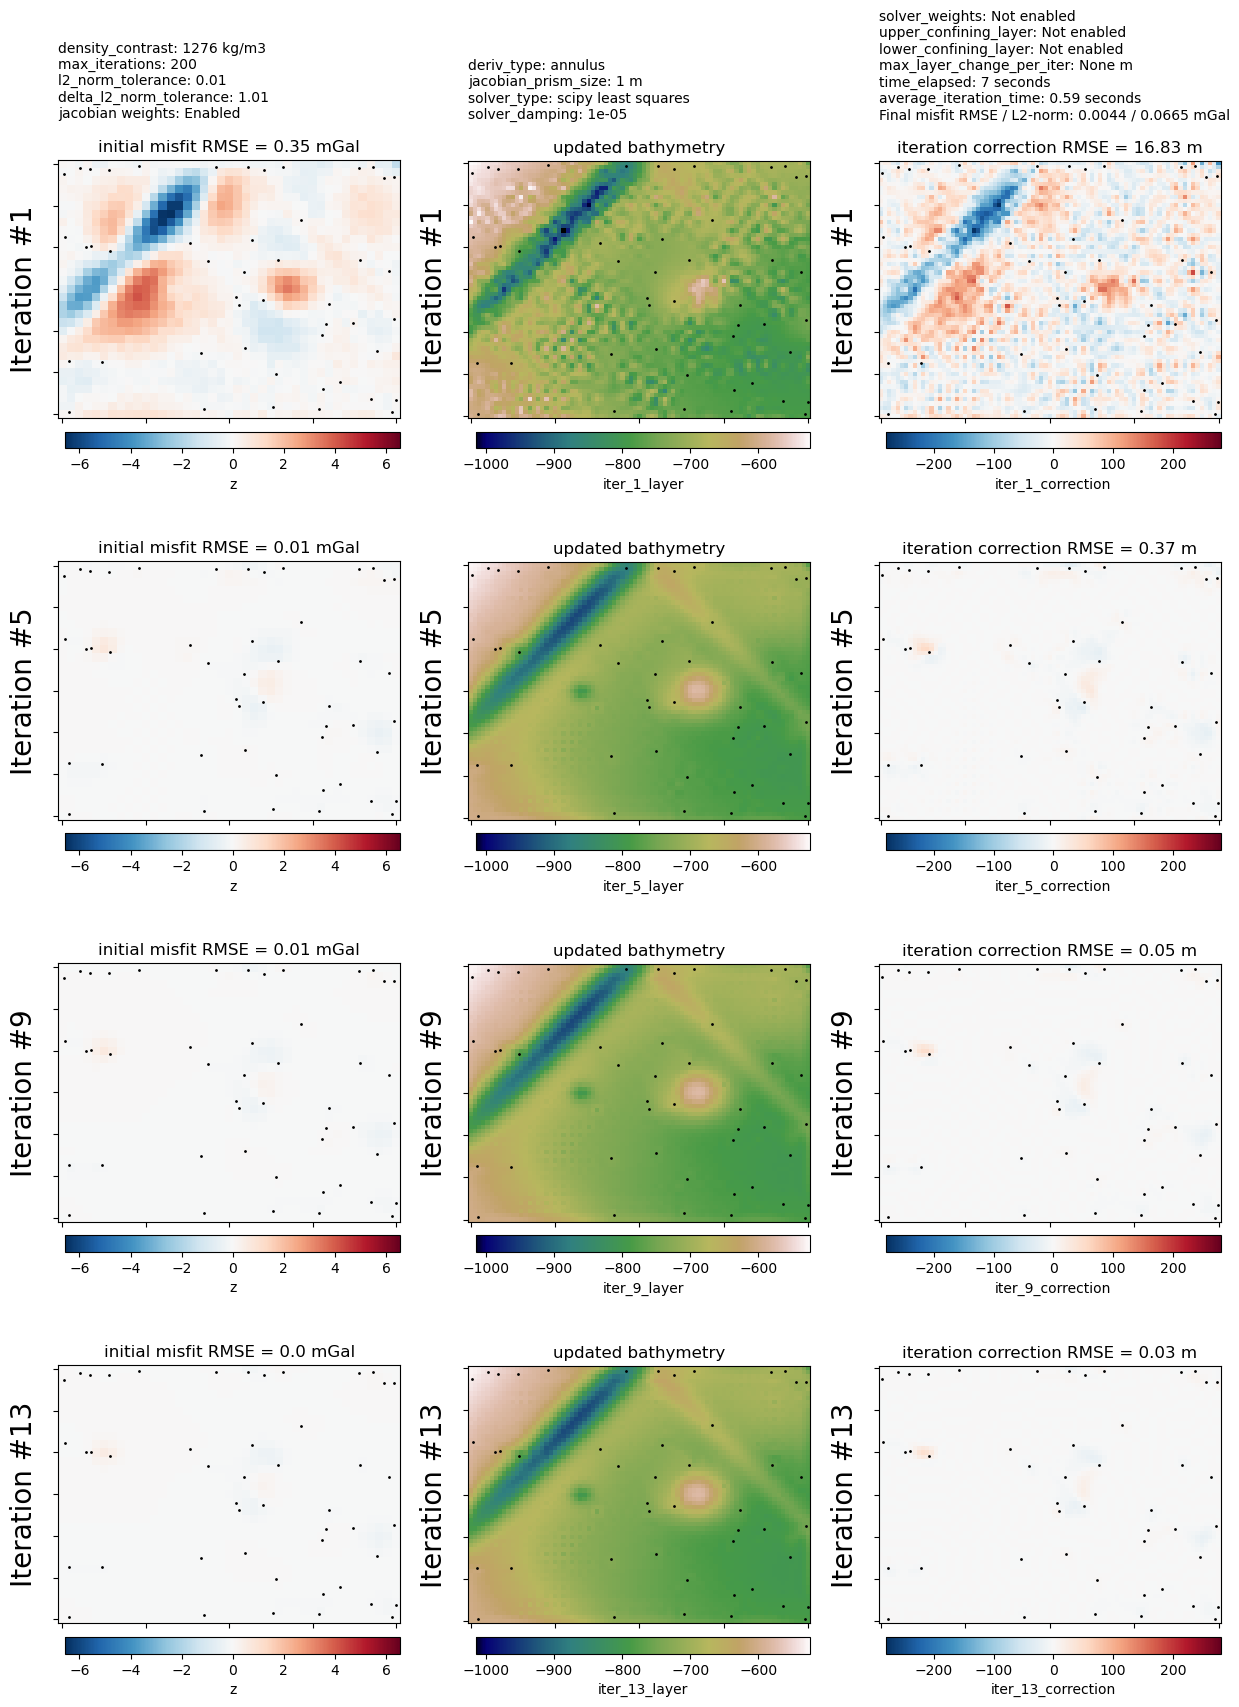

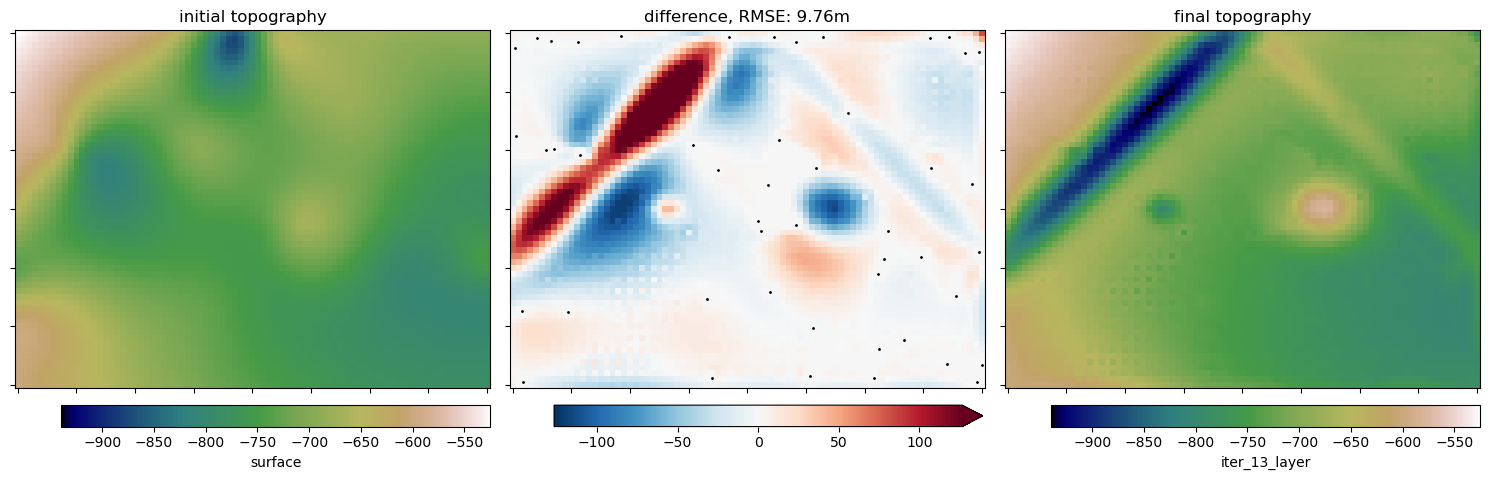

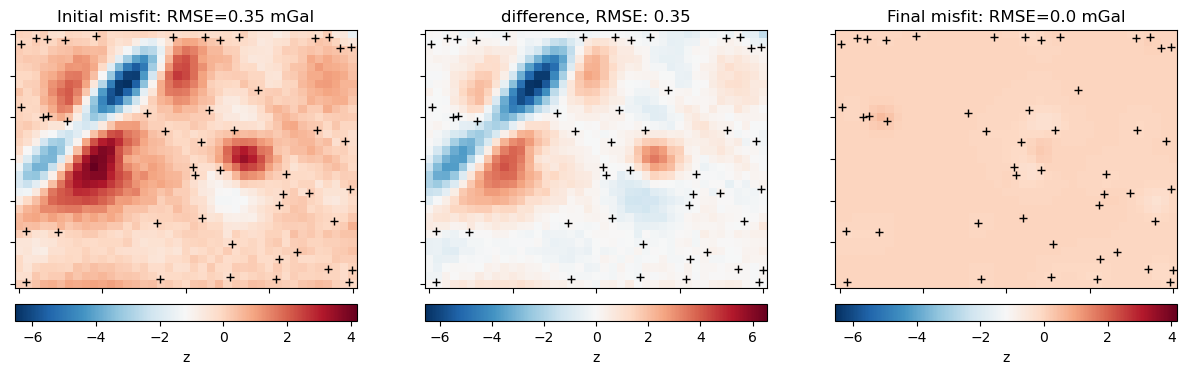

In [32]:
weights, _ = inv_utils.constraints_grid(
    constraint_points,  
    starting_prisms.drop("weights"),
    inner_bound=1e3, #study.best_params['weights_inner'],
    outer_bound=study.best_params['weights_outer'],
    low=0,
    high=1,
    # region=inversion_region,
    interp_type="spline",
)
        
starting_prisms["weights"] = weights
        
plotting.plot_best_inversion(
    true_surface=layer1,
    prism_layer = starting_prisms,
    best_params=study.best_params,
    grav_spacing=sampled_grav_spacing,
    constraint_points=constraint_points,
    plot_type="pygmt",
    **kwargs
)

# Repeat with synthetic survey